**A full ERD can be found [here](https://dbdiagram.io/d/638ce1b7bae3ed7c45449f75)**

# Data Description
In this task, few datasets are provided:

1. **`application_record.csv` -** this file contains appliers personal information, which you could use as features for data enrichment, in order to get better insights on the business use-case. The file contains ~438K records, and 18 columns.
The relevant columns this file has are:

	- `ID` - client number. Unique identifier for the customer holding the account
    - `AMT_INCOME_TOTAL` - annual income
    - `NAME_INCOME_TYPE` - income category
    - `NAME_EDUCATION_TYPE` - education level
    - `NAME_FAMILY_STATUS` - martial status
    - `NAME_HOUSING_TYPE` - way of living
    - `DAYS_BIRTH` - Count backwards from current day (0), -1 means yesterday
    - `DAYS_EMPLOYED` - Start date of employment; Count backwards from current day(0). If positive, person unemployed.
    - `OCCUPATION_TYPE` - Occupation
    
2. **`credit_record.csv` -** contains records users transactions of credit card. This dataset contains ~200K transactions, and has 3 columns:

    - `ID` - Client number
    - `MONTHS_BALANCE` - Record month; The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
    - `STATUS` - Status; A mapping column between a numerical value, and a range of time past due. Specifically - 0: 1-29 days past due; 1: 30-59 days past due; 2: 60-89 days overdue; 3: 90-119 days overdue; 4: 120-149 days overdue; 5: Overdue or bad debts, write-offs for more than 150 days; C: paid off that month X: No loan for the month

3. **`enriched_demographics_client.csv`** - this dataset contains some additional demographic information about each client. Specifically, it contains:
 
     - `ID` - Client number
     - `CODE_GENDER` - M (male) / F (female) of the client’s identity
     - `CNT_CHILDREN` - number of children
     - `CNT_FAM_MEMBERS` - Family size

4. ****`enriched_flags_client.csv`**** - this dataset contains some additional flags about each client. Specifically, it contains:
    - `ID` - Client number
    - `FLAG_MOBIL` - Is there a mobile phone
    - `FLAG_WORK_PHONE` - Is there a work phone
    - `FLAG_PHONE` - Is there a phone
    - `FLAG_EMAIL` - Is there an email
    - `FLAG_OWN_CAR` - Y (yes) / N (no) flag indicates if the client has a car
    - `FLAG_OWN_REALTY` - Y(yes) / N (no) indicates if the client has a property

# **DEEP DIVE ANALYSIS**

## Short Analysis

In [164]:
# Let's see how we can easily query the data
# Start working here if you choose to use Python for this part of the project
# Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [165]:
# Load data first and see its "head"
application_record_df = pd.read_csv("application_record.csv")
credit_record_df = pd.read_csv("credit_record.csv")
enriched_demographics_client_df = pd.read_csv("enriched_demographics_client.csv")
enriched_flags_client_df = pd.read_csv("enriched_flags_client.csv")

In [166]:
application_record_df.head(3)

DAYS_EMPLOYED NAME_FAMILY_STATUS  ...  AMT_INCOME_TOTAL NAME_INCOME_TYPE
0          -4542     Civil marriage  ...          427500.0          Working
1          -4542     Civil marriage  ...          427500.0          Working
2          -1134            Married  ...          112500.0          Working

[3 rows x 9 columns]

In [167]:
enriched_flags_client_df.head(3)

ID FLAG_OWN_CAR  ... FLAG_PHONE  FLAG_EMAIL
0  5008804            Y  ...          0           0
1  5008805            Y  ...          0           0
2  5008806            Y  ...          0           0

[3 rows x 7 columns]

In [168]:
enriched_demographics_client_df.head(3)

ID CODE_GENDER  CNT_CHILDREN  CNT_FAM_MEMBERS
0  5008804           M             0                2
1  5008805           M             0                2
2  5008806           M             0                2

In [169]:
# how many unique ID in application record?
len(set(application_record_df['ID']))

438510

In [170]:
# how many unique ID in credit record?
len(set(credit_record_df['ID']))

41628

In [171]:
# how many IDs do two tables share?
len(set(application_record_df['ID']).intersection(set(credit_record_df['ID'])))

32645

In [172]:
#define application_record_df
app_rec = application_record_df

In [173]:
#find value types and 
app_rec.dtypes

DAYS_EMPLOYED            int64
NAME_FAMILY_STATUS      object
DAYS_BIRTH               int64
NAME_HOUSING_TYPE       object
ID                       int64
NAME_EDUCATION_TYPE     object
OCCUPATION_TYPE         object
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
dtype: object

In [174]:
#find data shape
app_rec.shape

(438557, 9)

In [175]:
#find duplicates
app_rec.ID.duplicated().sum()

47

In [176]:
#find unique values
app_rec.nunique()

DAYS_EMPLOYED            9406
NAME_FAMILY_STATUS          5
DAYS_BIRTH              16379
NAME_HOUSING_TYPE           6
ID                     438510
NAME_EDUCATION_TYPE         5
OCCUPATION_TYPE            18
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
dtype: int64

In [177]:
#find null values
app_rec.isna().sum()

DAYS_EMPLOYED               0
NAME_FAMILY_STATUS          0
DAYS_BIRTH                  0
NAME_HOUSING_TYPE           0
ID                          0
NAME_EDUCATION_TYPE         0
OCCUPATION_TYPE        134203
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
dtype: int64

In [178]:
#summary statistics
app_rec.describe()

DAYS_EMPLOYED     DAYS_BIRTH            ID  AMT_INCOME_TOTAL
count  438557.000000  438557.000000  4.385570e+05      4.385570e+05
mean    60563.675328  -15997.904649  6.022176e+06      1.875243e+05
std    138767.799647    4185.030007  5.716370e+05      1.100869e+05
min    -17531.000000  -25201.000000  5.008804e+06      2.610000e+04
25%     -3103.000000  -19483.000000  5.609375e+06      1.215000e+05
50%     -1467.000000  -15630.000000  6.047745e+06      1.607805e+05
75%      -371.000000  -12514.000000  6.456971e+06      2.250000e+05
max    365243.000000   -7489.000000  7.999952e+06      6.750000e+06

In [179]:
#IQR
Q1 = app_rec.quantile(0.25)
Q3 = app_rec.quantile(0.75)
IQR = Q3 - Q1
outliers = (app_rec < (Q1 - 1.5 * IQR)) | (app_rec > (Q3 + 1.5 * IQR))

#columns with outliers
columns_with_outliers = outliers.columns[outliers.any()]
print(columns_with_outliers)


for col in app_rec.columns:
    if col in columns_with_outliers:
        print(f'Column {col} has {app_rec[outliers[col]][col].count()} outliers')
    else:
        continue

Index(['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'ID'], dtype='object')
Column DAYS_EMPLOYED has 97300 outliers
Column ID has 3243 outliers
Column AMT_INCOME_TOTAL has 19108 outliers


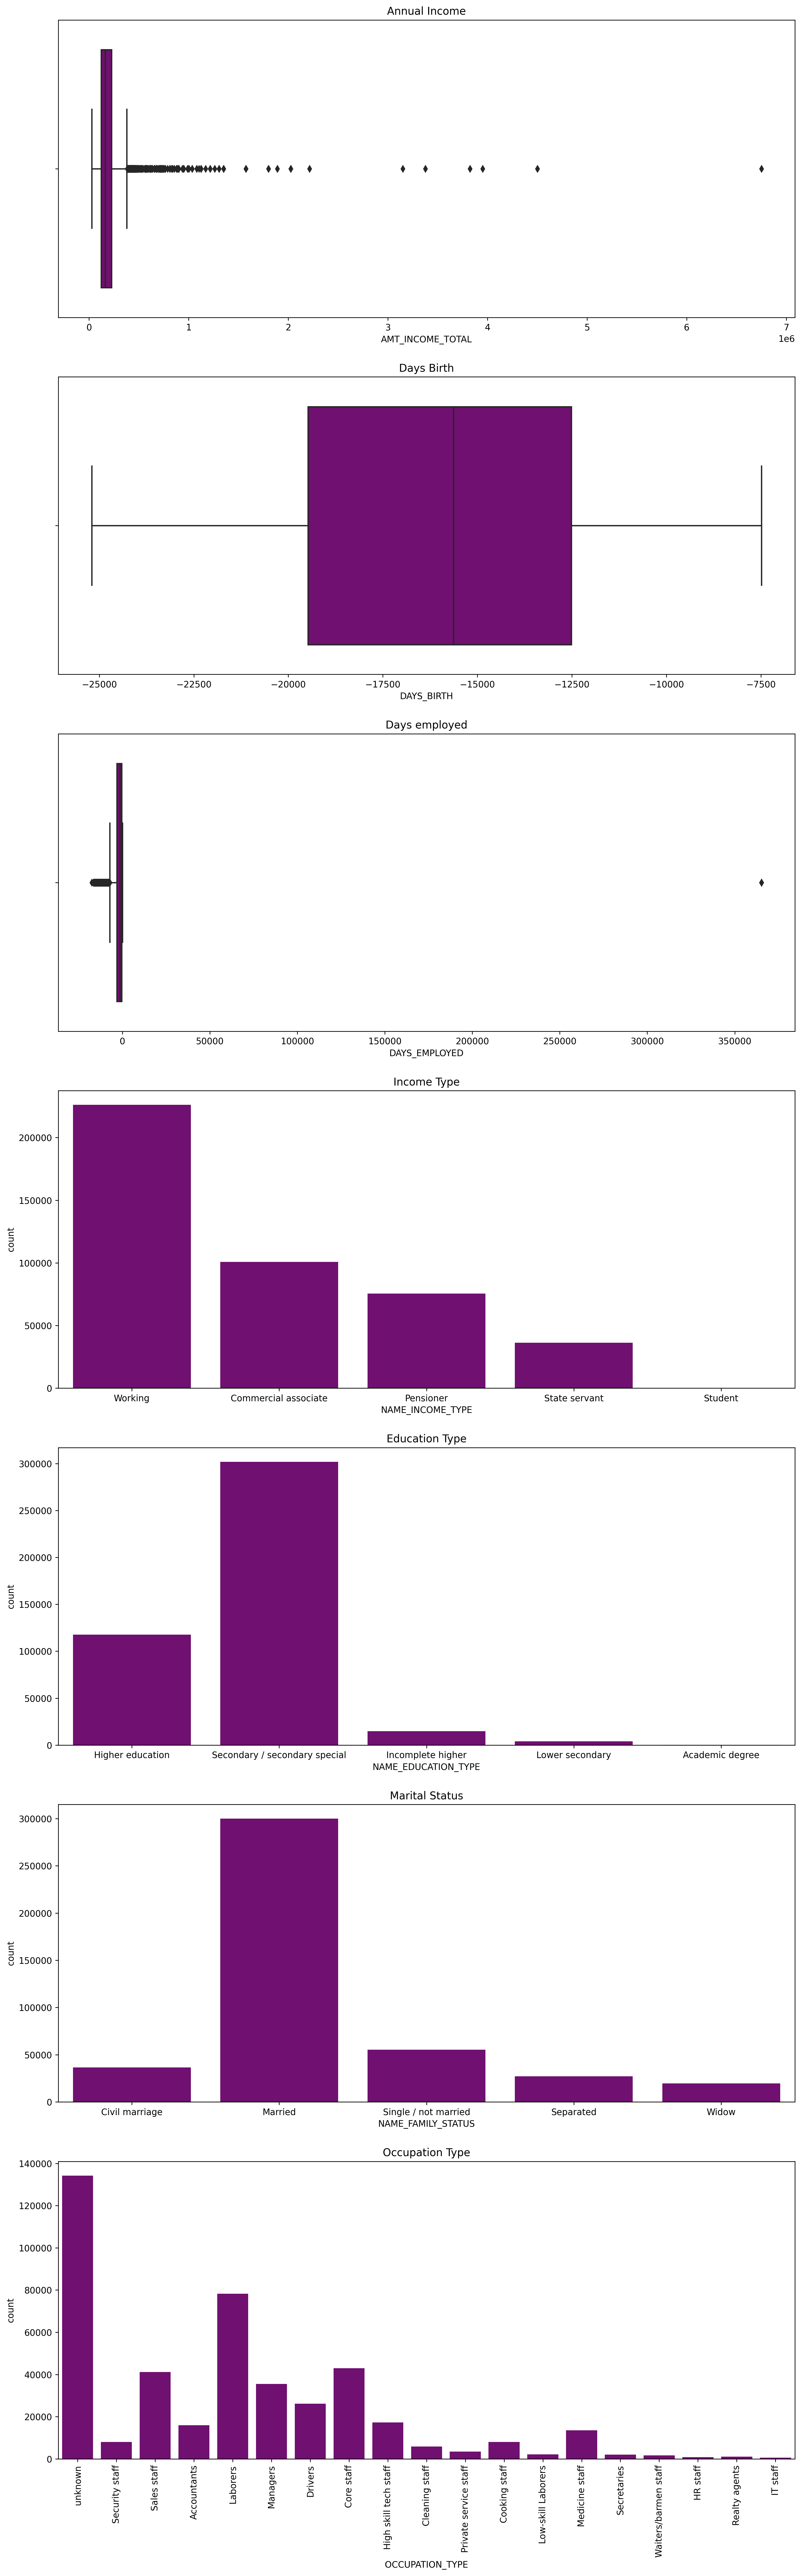

In [180]:
#OUTLIERS

# Create a figure with 7 subplots, one for each column
fig, axes = plt.subplots(7,1, figsize=(15, 50), dpi=250)

# Flatten the array of axes so that it's easier to index
axes = axes.flatten()

# Keep only the first 6 subplots
#axes = axes[:7]

# Annual income boxplot
sns.boxplot(x='AMT_INCOME_TOTAL', data=app_rec, color="purple", ax=axes[0])
axes[0].set_title('Annual Income')

# Days birth boxplot
sns.boxplot(x='DAYS_BIRTH', data=app_rec, color="purple", ax=axes[1])
axes[1].set_title('Days Birth')

# Days employed boxplot
sns.boxplot(x='DAYS_EMPLOYED', data=app_rec,color="purple", ax=axes[2])
axes[2].set_title('Days employed')

# Income Type countplot
sns.countplot(x='NAME_INCOME_TYPE', data=app_rec, color='purple', ax=axes[3])
axes[3].set_title('Income Type')

# Education type countplot
sns.countplot(x='NAME_EDUCATION_TYPE', data=app_rec, color='purple', ax=axes[4])
axes[4].set_title('Education Type')

# Marital status countplot
sns.countplot(x='NAME_FAMILY_STATUS', data=app_rec, color='purple', ax=axes[5]);
axes[5].set_title('Marital Status')

# occupation countplot
app_rec['OCCUPATION_TYPE'] = app_rec['OCCUPATION_TYPE'].fillna('unknown')
sns.countplot(x='OCCUPATION_TYPE', data=app_rec, color='purple', ax=axes[6])
axes[6].set_title('Occupation Type')
axes[6].set_xticklabels(axes[6].get_xticklabels(), rotation=90);

### Summary
The dataframe application_record_df is composed of integers, floats, and objects. Both day birth and days employed are typed as integers. The dataframe has 438,557 columns and 9 rows. The primary key,“ID”, has 438510 unique values. The Occupation column has 134203 missing values.

The summary statistics table revealed that the minimum days employed are -17531 while the maximum days employed are 365243; the standard deviation is about 138767.80. Also, the annual income column shows a minimum income of 2600 and a maximum of 67500000 with a large std of 110086.85. The variability in these columns is higher than desired, a visualization of these columns will show the presence of extreme values. This assumption was further confirmed through the calculation of the Interquartile Range (IQR), which identified the columns with outliers.

In [181]:
#define enriched_demographics_client_df
en_dem = enriched_demographics_client_df

In [182]:
#find value types
en_dem.dtypes

ID                  int64
CODE_GENDER        object
CNT_CHILDREN        int64
CNT_FAM_MEMBERS     int64
dtype: object

In [183]:
#find data shape
en_dem.shape

(438557, 4)

In [184]:
#determine unique values
en_dem.nunique()

ID                 438510
CODE_GENDER             2
CNT_CHILDREN           12
CNT_FAM_MEMBERS        13
dtype: int64

In [185]:
#find duplicates
en_dem.ID.duplicated().sum()

47

In [186]:
#find null values
en_dem.isna().sum()

ID                 0
CODE_GENDER        0
CNT_CHILDREN       0
CNT_FAM_MEMBERS    0
dtype: int64

In [187]:
#summary statistics
en_dem.describe()

ID   CNT_CHILDREN  CNT_FAM_MEMBERS
count  4.385570e+05  438557.000000    438557.000000
mean   6.022176e+06       0.427390         2.194465
std    5.716370e+05       0.724882         0.897207
min    5.008804e+06       0.000000         1.000000
25%    5.609375e+06       0.000000         2.000000
50%    6.047745e+06       0.000000         2.000000
75%    6.456971e+06       1.000000         3.000000
max    7.999952e+06      19.000000        20.000000

In [188]:
#IQR
Q1 = en_dem.quantile(0.25)
Q3 = en_dem.quantile(0.75)
IQR = Q3 - Q1
outliers = (en_dem < (Q1 - 1.5 * IQR)) | (en_dem > (Q3 + 1.5 * IQR))

#columns with outliers
columns_with_outliers = outliers.columns[outliers.any()]
print(columns_with_outliers)

for col in en_dem.columns:
    if col in columns_with_outliers:
        print(f'Column {col} has {en_dem[outliers[col]][col].count()} outliers')
    else:
        continue

Index(['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'ID'], dtype='object')
Column ID has 3243 outliers
Column CNT_CHILDREN has 6075 outliers
Column CNT_FAM_MEMBERS has 5690 outliers


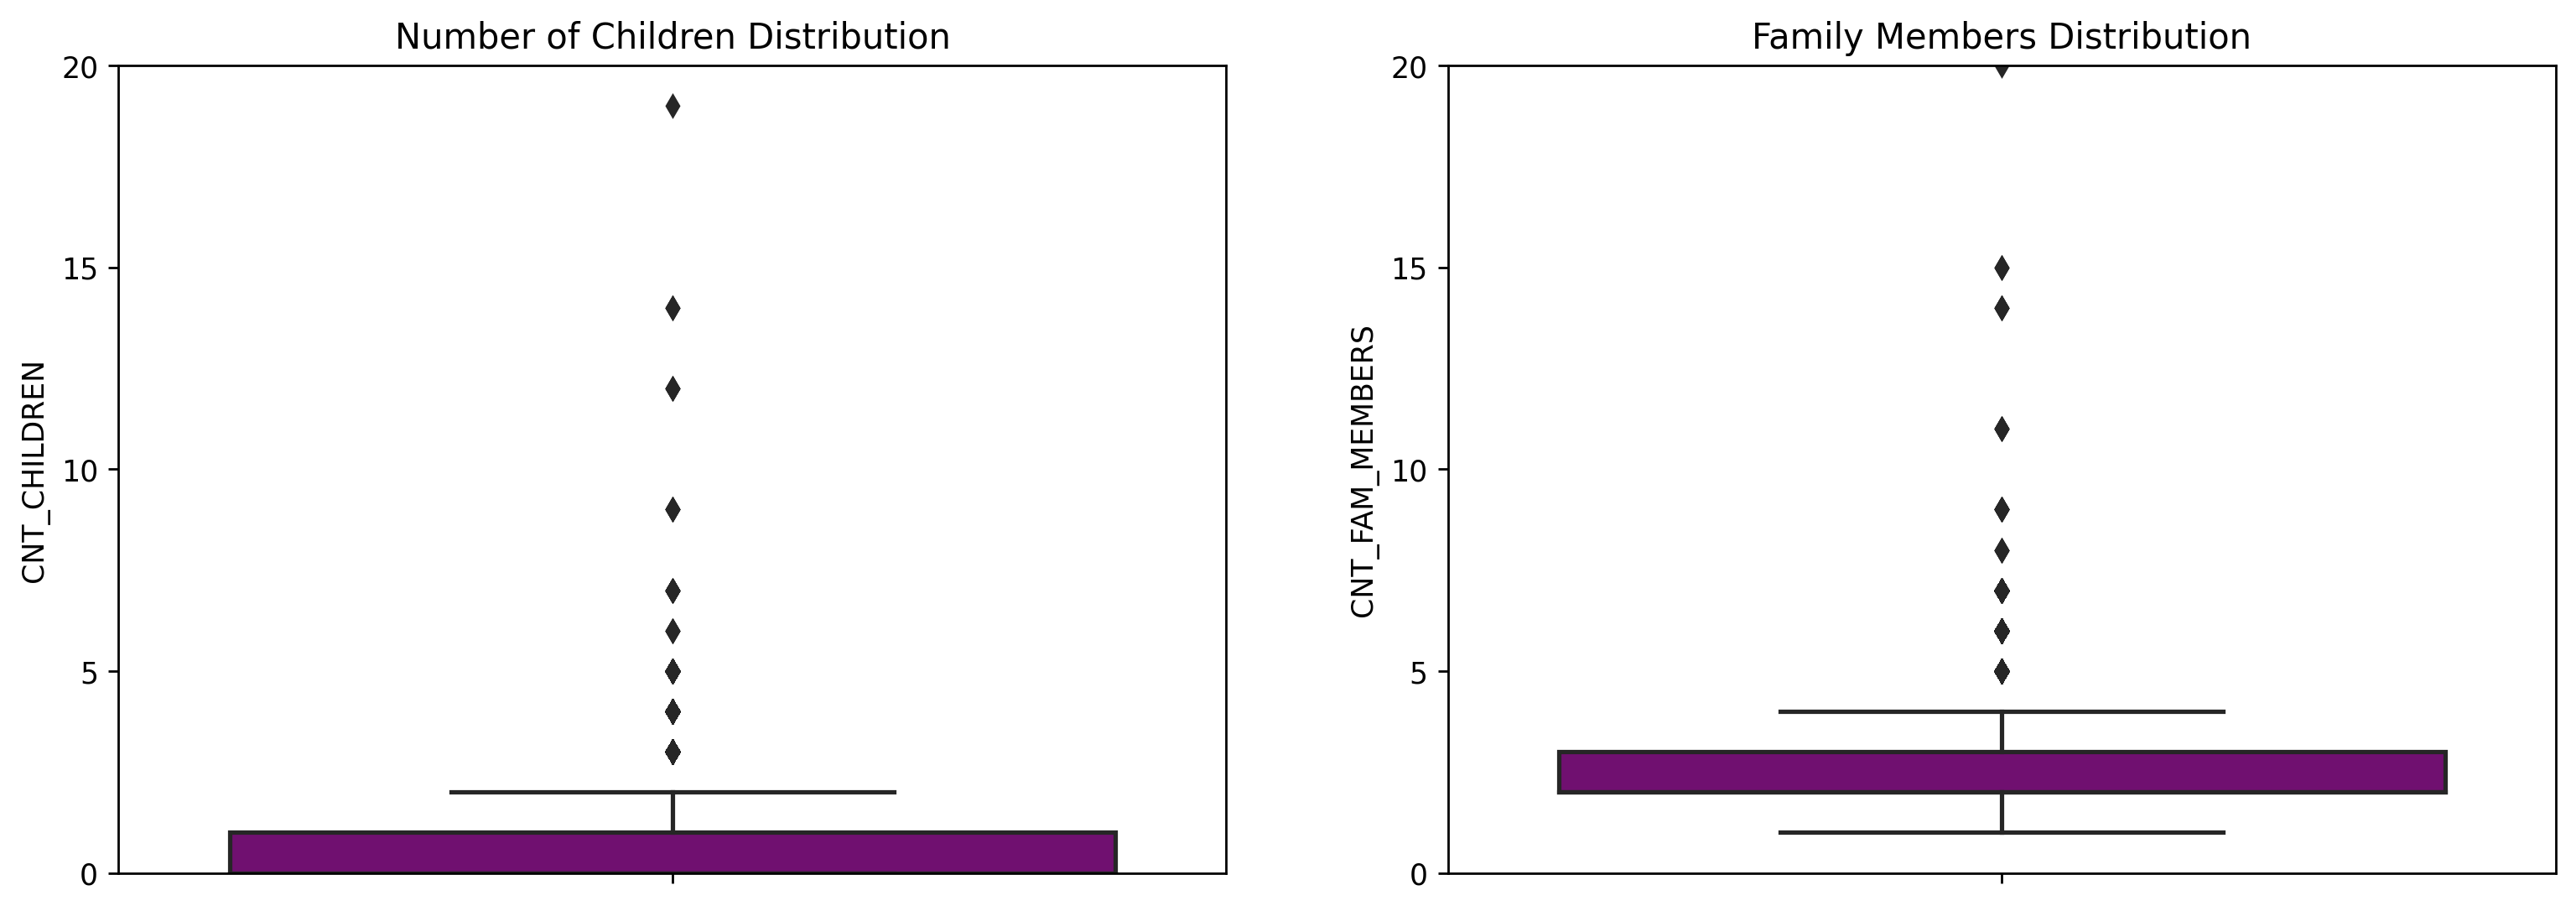

In [189]:
#OUTLIERS

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=250)

# Annual income boxplot
sns.boxplot(y='CNT_CHILDREN', data=en_dem, color="purple", ax=axes[0],showfliers=True)
axes[0].set_ylim(0, en_dem['CNT_CHILDREN'].max())
axes[0].yaxis.set_ticks(np.arange(0, en_dem['CNT_CHILDREN'].max()+5, 5))
axes[0].set_title('Number of Children Distribution')

# Days birth boxplot
sns.boxplot(y='CNT_FAM_MEMBERS', data=en_dem, color="purple", ax=axes[1])
axes[1].set_ylim(0, en_dem['CNT_FAM_MEMBERS'].max())
axes[1].yaxis.set_ticks(np.arange(0, en_dem['CNT_FAM_MEMBERS'].max()+5, 5))
axes[1].set_title('Family Members Distribution');

### Summary
The enriched_demographics_client_df contains 438557 row and 4 columns. The primary key has 438510 unique values in this dataframe. There are no null values. Both the count children and the count family members column show sign of outliers.  

In [190]:
#define credit_record_df
cre_rec = credit_record_df

In [191]:
#data type
cre_rec.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [192]:
#find data shape
cre_rec.shape

(209715, 3)

In [193]:
#find duplicates
cre_rec.ID.duplicated().sum()

168087

In [194]:
#find unique values
cre_rec.nunique()

ID                41628
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [195]:
#find null values
cre_rec.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [196]:
#summary startistics
cre_rec.describe()

ID  MONTHS_BALANCE
count  2.097150e+05   209715.000000
mean   5.068317e+06      -19.148621
std    4.618943e+04       14.019924
min    5.001712e+06      -60.000000
25%    5.023661e+06      -29.000000
50%    5.062089e+06      -17.000000
75%    5.113884e+06       -7.000000
max    5.150487e+06        0.000000

In [197]:
#IQR
Q1 = cre_rec.quantile(0.25)
Q3 = cre_rec.quantile(0.75)
IQR = Q3 - Q1
outliers = (cre_rec < (Q1 - 1.5 * IQR)) | (cre_rec > (Q3 + 1.5 * IQR))

#columns with outliers
columns_with_outliers = outliers.columns[outliers.any()]
print(columns_with_outliers)

for col in cre_rec.columns:
    if col in columns_with_outliers:
        print(f'Column {col} has {cre_rec[outliers[col]][col].count()} outliers')
    else:
        continue

Index([], dtype='object')


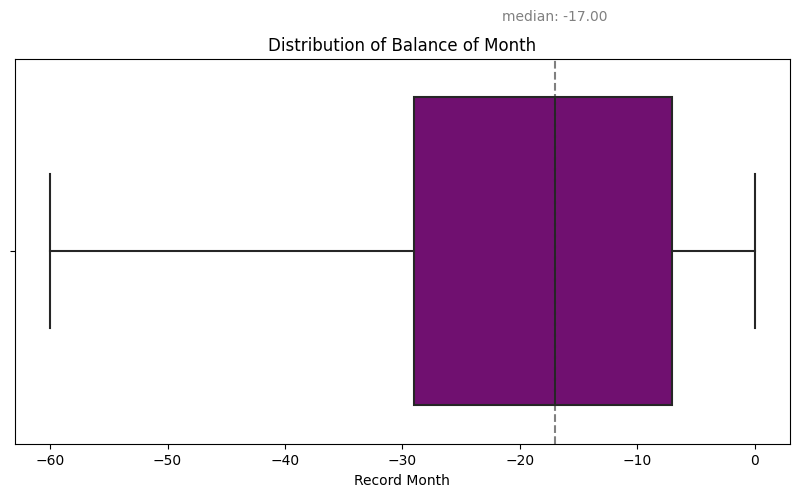

In [198]:
#outliers?  

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# create boxplot 
sns.boxplot(x='MONTHS_BALANCE', data=cre_rec, color='purple', ax=ax)

#calculate median
median = np.median(cre_rec['MONTHS_BALANCE'])

#create vertical line and median value text
plt.axvline(median, color='grey', linestyle='--')
plt.text(median, ax.get_ylim()[1] - 0.10, f"median: {median:.2f}", ha="center", color='grey')

plt.xlabel('Record Month')
plt.title('Distribution of Balance of Month');

### Summary
credit_record_df has 209715 rows and 3 columns. There are 41628 unique values for the ID column, however, since the same client can have more than one activity, this is not a concern. There are no null values and no outliers.

In [199]:
#define enriched_flags_client_df
enr_flg = enriched_flags_client_df

In [200]:
#data type
enr_flg.dtypes

ID                  int64
FLAG_OWN_CAR       object
FLAG_OWN_REALTY    object
FLAG_MOBIL          int64
FLAG_WORK_PHONE     int64
FLAG_PHONE          int64
FLAG_EMAIL          int64
dtype: object

In [201]:
#find data shape
enr_flg.shape

(438557, 7)

In [202]:
#find duplicates
enr_flg.ID.duplicated().sum()

47

In [203]:
#find unique values
enr_flg.nunique()

ID                 438510
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
FLAG_MOBIL              1
FLAG_WORK_PHONE         2
FLAG_PHONE              2
FLAG_EMAIL              2
dtype: int64

In [204]:
#find null values
enr_flg.isna().sum()

ID                 0
FLAG_OWN_CAR       0
FLAG_OWN_REALTY    0
FLAG_MOBIL         0
FLAG_WORK_PHONE    0
FLAG_PHONE         0
FLAG_EMAIL         0
dtype: int64

In [205]:
#summary startistics
enr_flg.describe()

ID  FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE     FLAG_EMAIL
count  4.385570e+05    438557.0    438557.000000  438557.000000  438557.000000
mean   6.022176e+06         1.0         0.206133       0.287771       0.108207
std    5.716370e+05         0.0         0.404527       0.452724       0.310642
min    5.008804e+06         1.0         0.000000       0.000000       0.000000
25%    5.609375e+06         1.0         0.000000       0.000000       0.000000
50%    6.047745e+06         1.0         0.000000       0.000000       0.000000
75%    6.456971e+06         1.0         0.000000       1.000000       0.000000
max    7.999952e+06         1.0         1.000000       1.000000       1.000000

In [206]:
#IQR
Q1 = enr_flg.quantile(0.25)
Q3 = enr_flg.quantile(0.75)
IQR = Q3 - Q1
outliers = (enr_flg < (Q1 - 1.5 * IQR)) | (enr_flg > (Q3 + 1.5 * IQR))

#columns with outliers
columns_with_outliers = outliers.columns[outliers.any()]
print(columns_with_outliers)

for col in enr_flg.columns:
    if col in columns_with_outliers:
        print(f'Column {col} has {enr_flg[outliers[col]][col].count()} outliers')
    else:
        continue

Index(['FLAG_EMAIL', 'FLAG_WORK_PHONE', 'ID'], dtype='object')
Column ID has 3243 outliers
Column FLAG_WORK_PHONE has 90401 outliers
Column FLAG_EMAIL has 47455 outliers


### Summary
enriched_flags_client_df has 438557 rows and 7 columns. Although the dataframe shows both flag car and realty as objects, it shows all the other columns as integers. These columns are asking Y/N questions. The answers should be either ‘yes' or 'no'. The ID columns contains 438510 unique values and there are no null values. The columns email and work phone come up as having outliers. This may be due to the fact that the values are 1 and 0.

## Data Cleaning

In [207]:
#make copy of original datas before cleaning
app_rec_copy = application_record_df.copy()
en_dem_copy= enriched_demographics_client_df.copy()
cre_rec_copy= credit_record_df.copy()
enr_flg_copy = enriched_flags_client_df.copy()

**For application_record_df**

In [208]:
#add column transforming DAYS_BIRTH into something more understandable. name of the new column: BIRTH_DATE
app_rec_copy ['BIRTH_DATE'] = pd.to_datetime(app_rec_copy ['DAYS_BIRTH'], unit='D', origin='today').dt.strftime('%Y-%m-%d')

#convert from object to date
app_rec_copy['BIRTH_DATE'] = pd.to_datetime(app_rec_copy['BIRTH_DATE'], format='%Y-%m-%d')

#drop unwanted column
app_rec_copy =app_rec_copy .drop(['DAYS_BIRTH'], axis = 1)
app_rec_copy.dtypes

DAYS_EMPLOYED                   int64
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
ID                              int64
NAME_EDUCATION_TYPE            object
OCCUPATION_TYPE                object
AMT_INCOME_TOTAL              float64
NAME_INCOME_TYPE               object
BIRTH_DATE             datetime64[ns]
dtype: object

DAYS_BIRTH is a very confusing notion. Therefore, in order to make it more understandable, I change created a new column and changed its type. I also dropped the original column as it is no longer useful.

In [209]:
# Remove duplicated ID 
app_rec_copy = app_rec_copy.drop_duplicates(subset=['ID'], keep = 'last')
app_rec_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438510 entries, 0 to 438556
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DAYS_EMPLOYED        438510 non-null  int64         
 1   NAME_FAMILY_STATUS   438510 non-null  object        
 2   NAME_HOUSING_TYPE    438510 non-null  object        
 3   ID                   438510 non-null  int64         
 4   NAME_EDUCATION_TYPE  438510 non-null  object        
 5   OCCUPATION_TYPE      438510 non-null  object        
 6   AMT_INCOME_TOTAL     438510 non-null  float64       
 7   NAME_INCOME_TYPE     438510 non-null  object        
 8   BIRTH_DATE           438510 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 33.5+ MB


In [210]:
#dealing with the null values in occupation

#app_rec_copy.dropna(subset=['OCCUPATION_TYPE'], inplace=True)
#app_rec_copy['OCCUPATION_TYPE'].isna().sum()
app_rec_copy['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
app_rec_copy['OCCUPATION_TYPE'].isna().sum()

0

I thought of dropping the null values in the occupation type column. However, dropping the null values may have negativelly affected the integrity of the df. Thefore, I decided to replace the null values with 'unknown'

**For enriched_flags_client_df**

In [211]:
#change mistyped columns
#enr_flg_copy[['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_PHONE' ]] = enr_flg_copy[['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_PHONE' ]].replace({1: 'Y', 0: 'N'})
#enr_flg_copy.dtypes

#drop unwanted columns 
enr_flg_copy=enr_flg_copy.drop(['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'FLAG_PHONE'], axis = 1)
enr_flg_copy.dtypes

ID                  int64
FLAG_OWN_CAR       object
FLAG_OWN_REALTY    object
dtype: object

'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE' and 'FLAG_EMAIL have been deleted as they did not seem necessary for our analysis

**For enriched_demographics_clients_df**

In [212]:
# Remove duplicated ID 
en_dem_copy = en_dem_copy.drop_duplicates(subset=['ID'], keep = 'last')
en_dem_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438510 entries, 0 to 438556
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               438510 non-null  int64 
 1   CODE_GENDER      438510 non-null  object
 2   CNT_CHILDREN     438510 non-null  int64 
 3   CNT_FAM_MEMBERS  438510 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 16.7+ MB


**For enriched_flag_client_df**

In [213]:
# Remove duplicated ID 
enr_flg_copy = enr_flg_copy.drop_duplicates(subset=['ID'], keep = 'last')
enr_flg_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438510 entries, 0 to 438556
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               438510 non-null  int64 
 1   FLAG_OWN_CAR     438510 non-null  object
 2   FLAG_OWN_REALTY  438510 non-null  object
dtypes: int64(1), object(2)
memory usage: 13.4+ MB


In [214]:
#make copy of cleaned data before analysis
app_rec_clean = app_rec_copy.copy()
en_dem_clean= en_dem_copy.copy()
cre_rec_clean= cre_rec_copy.copy()
enr_flg_clean= enr_flg_copy.copy()

In [215]:
#combine all dfs
app_rec_en_dem = app_rec_clean.merge(en_dem_clean, on='ID', how= 'inner')
app_rec_en_dem_cre_rec= app_rec_en_dem.merge(cre_rec_clean, on='ID', how= 'inner')
df_merged = app_rec_en_dem_cre_rec.merge(enr_flg_clean, on='ID', how= 'inner')

In [216]:
df_merged.isna().sum()

DAYS_EMPLOYED          0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
ID                     0
NAME_EDUCATION_TYPE    0
OCCUPATION_TYPE        0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
BIRTH_DATE             0
CODE_GENDER            0
CNT_CHILDREN           0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
STATUS                 0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
dtype: int64

In [217]:
df_merged.shape

(155516, 16)

In [218]:
#save new df
df_merged.to_csv("df_merged.csv", index=False)

In [219]:
#replace outliers with median value

columns_with_out = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS' ]

for col in columns_with_out:
    median = df_merged[col].median()
    Q1 = df_merged[col].quantile(0.25)
    Q3 = df_merged[col].quantile(0.75)
    IQR = Q3 - Q1
    up_bound = Q3 + 1.5 * IQR
    low_bound = Q1 - 1.5 * IQR
    df_merged.loc[(df_merged[col] > up_bound) | (df_merged[col] < low_bound), col] = median


In [220]:
df_merged.head()

DAYS_EMPLOYED NAME_FAMILY_STATUS  ... FLAG_OWN_CAR  FLAG_OWN_REALTY
0          -4542     Civil marriage  ...            Y                Y
1          -4542     Civil marriage  ...            Y                Y
2          -4542     Civil marriage  ...            Y                Y
3          -4542     Civil marriage  ...            Y                Y
4          -4542     Civil marriage  ...            Y                Y

[5 rows x 16 columns]

In [221]:
df_merged.describe()

DAYS_EMPLOYED            ID  ...  CNT_FAM_MEMBERS  MONTHS_BALANCE
count  155516.000000  1.555160e+05  ...    155516.000000   155516.000000
mean    -2229.990618  5.078752e+06  ...         2.164742      -19.400730
std      1564.323746  4.182775e+04  ...         0.823252       14.084104
min     -7557.000000  5.008804e+06  ...         1.000000      -60.000000
25%     -2970.000000  5.044675e+06  ...         2.000000      -29.000000
50%     -1680.000000  5.074593e+06  ...         2.000000      -17.000000
75%     -1262.000000  5.115548e+06  ...         3.000000       -8.000000
max       -17.000000  5.150487e+06  ...         4.000000        0.000000

[8 rows x 6 columns]

In [222]:
df_merged.dtypes

DAYS_EMPLOYED                   int64
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
ID                              int64
NAME_EDUCATION_TYPE            object
OCCUPATION_TYPE                object
AMT_INCOME_TOTAL              float64
NAME_INCOME_TYPE               object
BIRTH_DATE             datetime64[ns]
CODE_GENDER                    object
CNT_CHILDREN                    int64
CNT_FAM_MEMBERS                 int64
MONTHS_BALANCE                  int64
STATUS                         object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
dtype: object

## Distribution Analysis

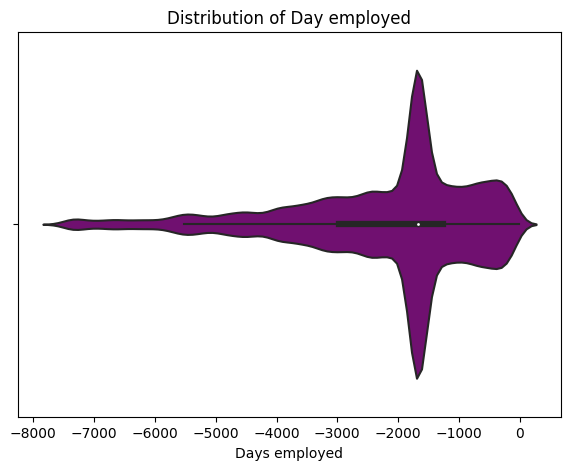

In [223]:
#DAYS_EMPLOYED        
plt.figure(figsize=(7,5))

# Create violinplot
sns.violinplot(x='DAYS_EMPLOYED', data=df_merged, color='Purple')

plt.xlabel('Days employed')
plt.title('Distribution of Day employed');

The distribution shows the majority of the days employed being under zero with the peak numbers being a little under 1500 days (the median). No unemployed in this distribution. 

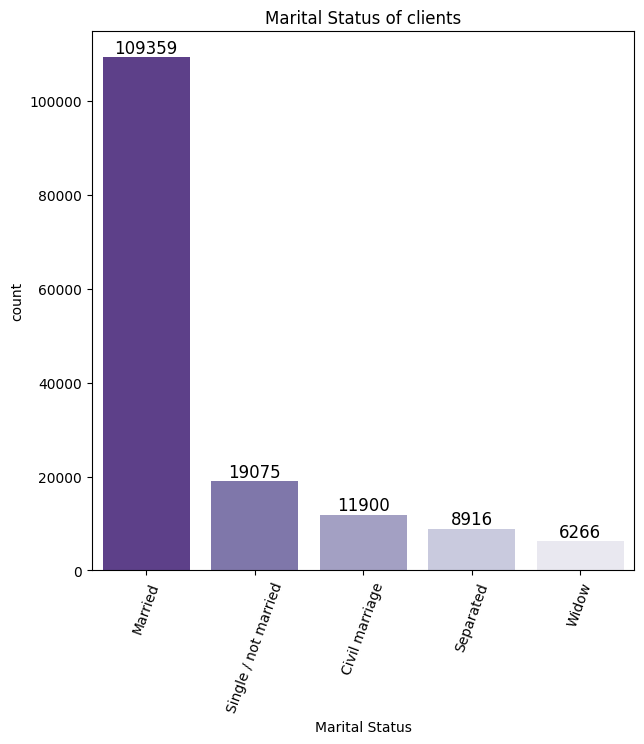

In [224]:
#NAME_FAMILY_STATUS   
plt.figure(figsize=(7,7))

# Create and sort countplot
counts = df_merged['NAME_FAMILY_STATUS'].value_counts()

# Plot the countplot
g=sns.countplot(x='NAME_FAMILY_STATUS', data=df_merged, order=counts.index,palette='Purples_r')
plt.xticks(rotation=70)
plt.xlabel('Marital Status')
plt.title('Marital Status of clients')

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom');

The most popular marital status is "married" followed by single, civil marriage, separated and widow

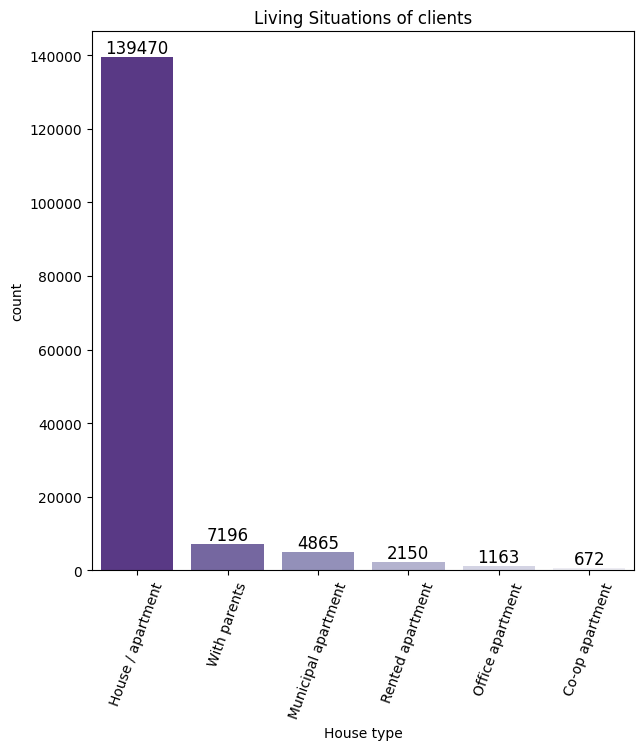

In [225]:
#NAME_HOUSING_TYPE       
plt.figure(figsize=(7,7))

# Create and sort countplot
counts = df_merged['NAME_HOUSING_TYPE'].value_counts()

# Plot the countplot
g=sns.countplot(x='NAME_HOUSING_TYPE', data=df_merged, order=counts.index,palette='Purples_r')
plt.xticks(rotation=70)
plt.xlabel('House type')
plt.title('Living Situations of clients')

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom');

139470 clients live in house/apartment, while the rest either live with parents, municipal apartments, office apartments or co-op apartments. It is worth noting that the gap between the most popular living situation is considerable.

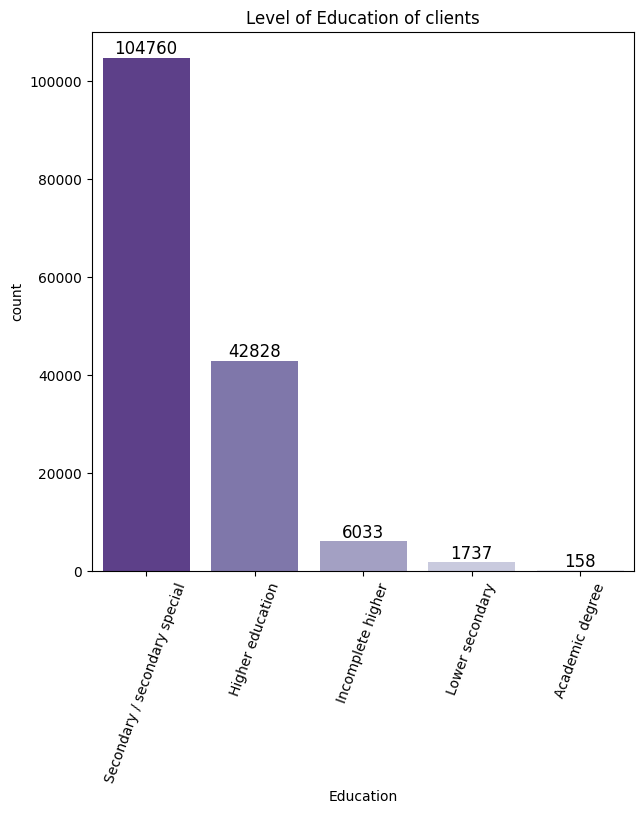

In [226]:
#NAME_EDUCATION_TYPE
plt.figure(figsize=(7,7))

# Create and sort countplot
counts = df_merged['NAME_EDUCATION_TYPE'].value_counts()

# Plot the countplot
g=sns.countplot(x='NAME_EDUCATION_TYPE', data=df_merged, order=counts.index,palette='Purples_r')
plt.xticks(rotation=70)
plt.xlabel('Education')
plt.title('Level of Education of clients')

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom');

Majority of clients finished secondary school and only 158 have an academic degree. 

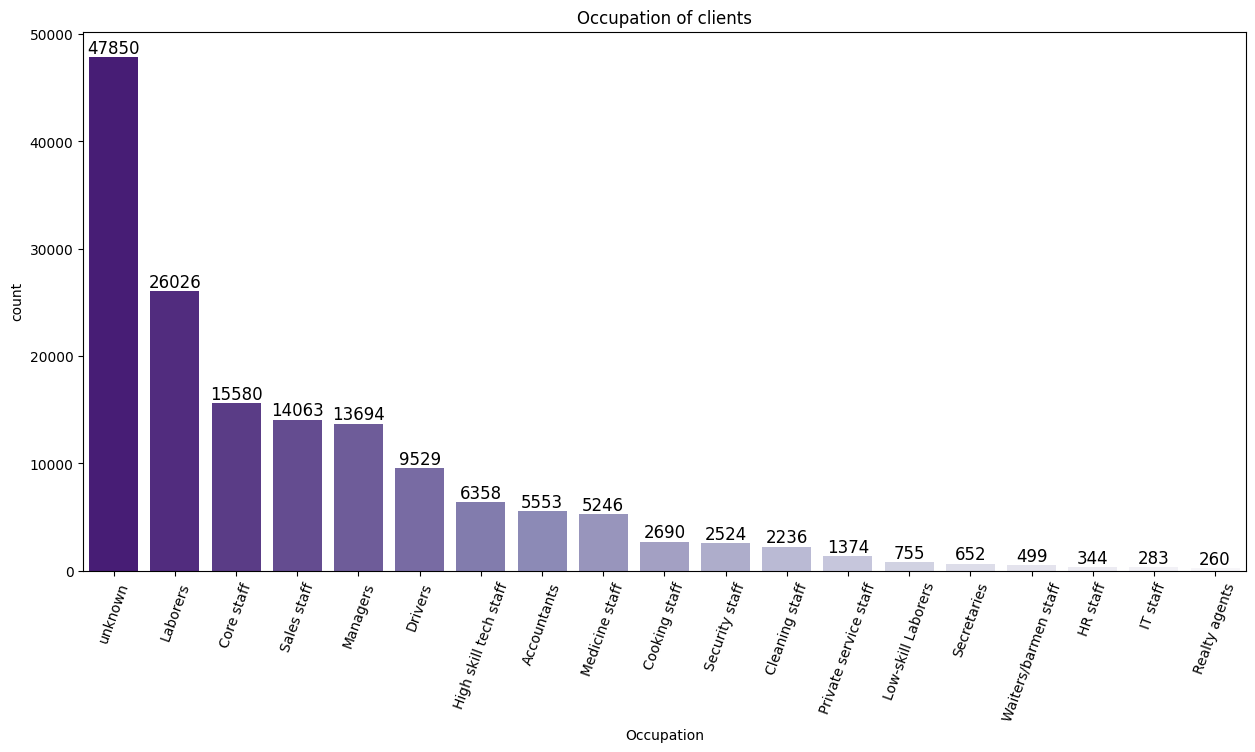

In [227]:
#OCCUPATION_TYPE        
plt.figure(figsize=(15,7))

# Create and sort countplot
counts = df_merged['OCCUPATION_TYPE'].value_counts()

# Plot the countplot
g=sns.countplot(x='OCCUPATION_TYPE', data=df_merged, order=counts.index, palette='Purples_r')
plt.xticks(rotation=70)
plt.xlabel('Occupation')
plt.title('Occupation of clients')

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom');

The occupation for the majority of the clients is unknown (these were originally null values). The null values may have been due to data entry errors, missing data or incomplete data collection. Given the number if missing values, dropping them would have compromised the dataframe, and we may be able to find the information in the future.

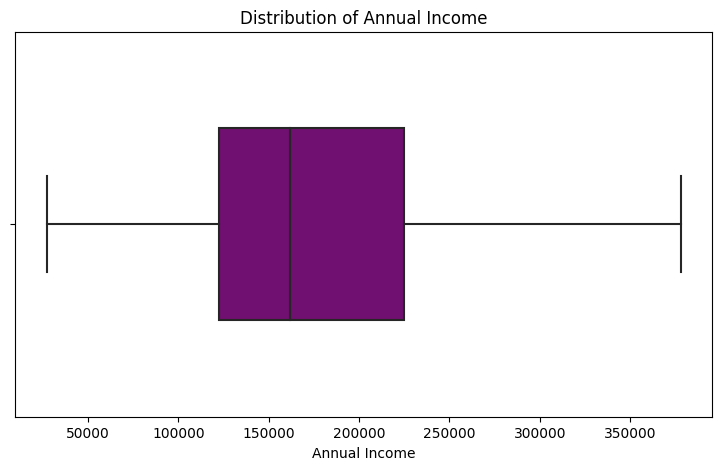

In [228]:
#AMT_INCOME_TOTAL             
plt.figure(figsize=(9,5))

#plot boxplot
sns.boxplot( x='AMT_INCOME_TOTAL', data=df_merged,width=0.5,color='purple')
plt.xlabel('Annual Income')
plt.title('Distribution of Annual Income');

The lower limit of this distribution is under 50K with the median being between 150K and 200K, and with the outliers starting at just over 350K.

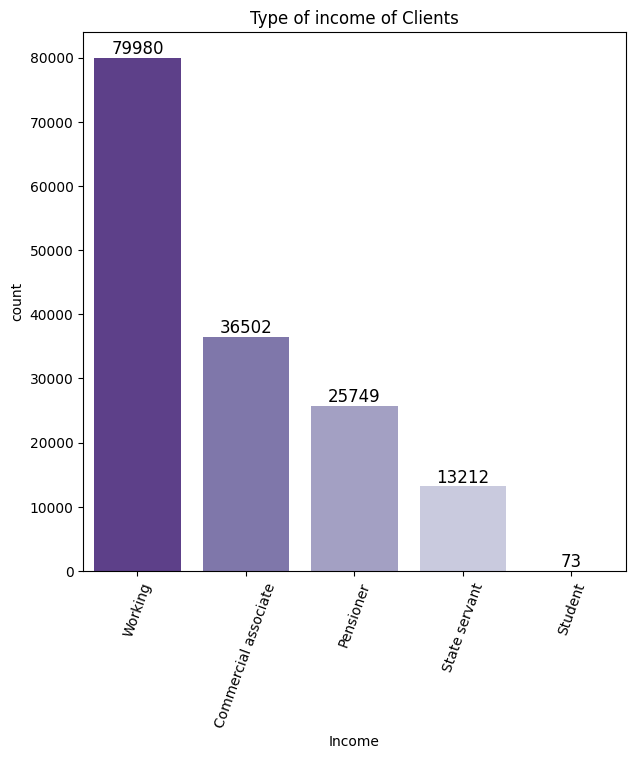

In [229]:
#NAME_INCOME_TYPE
plt.figure(figsize=(7,7))

# Create and sort countplot
counts = df_merged['NAME_INCOME_TYPE'].value_counts()

# Plot the countplot
g=sns.countplot(x='NAME_INCOME_TYPE', data=df_merged, order=counts.index,palette='Purples_r')
plt.xticks(rotation=70)
plt.xlabel('Income')
plt.title('Type of income of Clients')

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom');

The majority of the clients are working and only a small fraction are students

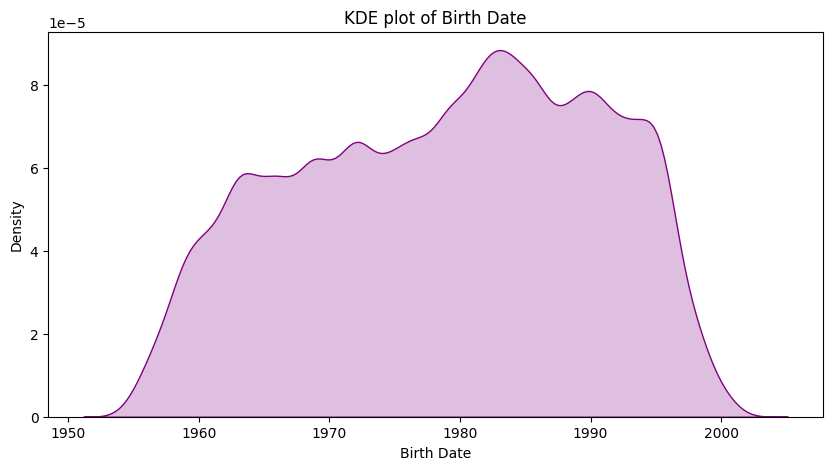

In [230]:
#BIRTH_DATE     

#create kdeplot
plt.figure(figsize=(10,5))
sns.kdeplot(df_merged['BIRTH_DATE'], shade=True,color='purple')
plt.xlabel('Birth Date')
plt.title('KDE plot of Birth Date');

The majority of the clients were born between 1980 and 1990

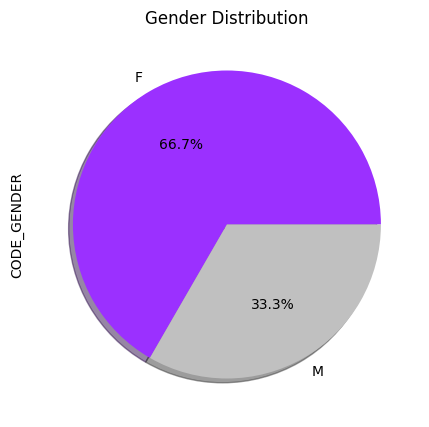

In [231]:
#CODE_GENDER

#Create the pieplot for gender code
colors = ['#9B30FF', '#C0C0C0']
plt.figure(figsize=(5,5))
df_merged['CODE_GENDER'].value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%', colors=colors);
plt.title('Gender Distribution');



over 65% are female

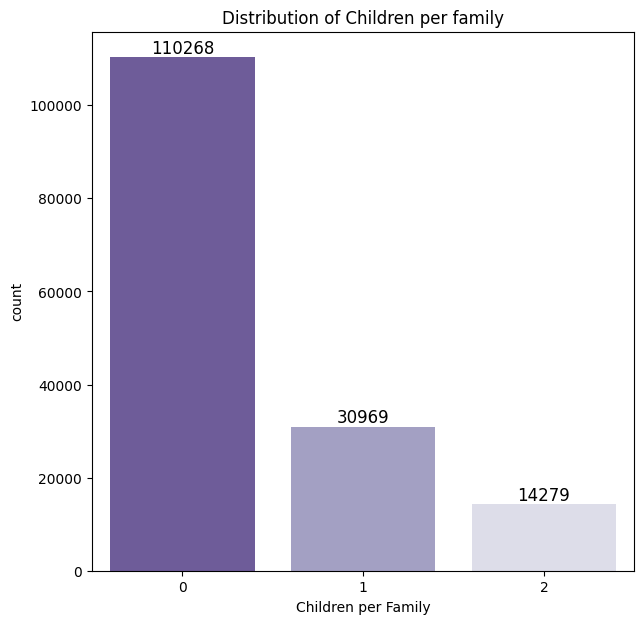

In [232]:
#CNT_CHILDREN        
plt.figure(figsize=(7,7))

#Create the countplot for number of children per family
g=sns.countplot(x='CNT_CHILDREN', data= df_merged, palette='Purples_r')
plt.xlabel('Children per Family')
plt.title('Distribution of Children per family');

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

Most families are child-free.

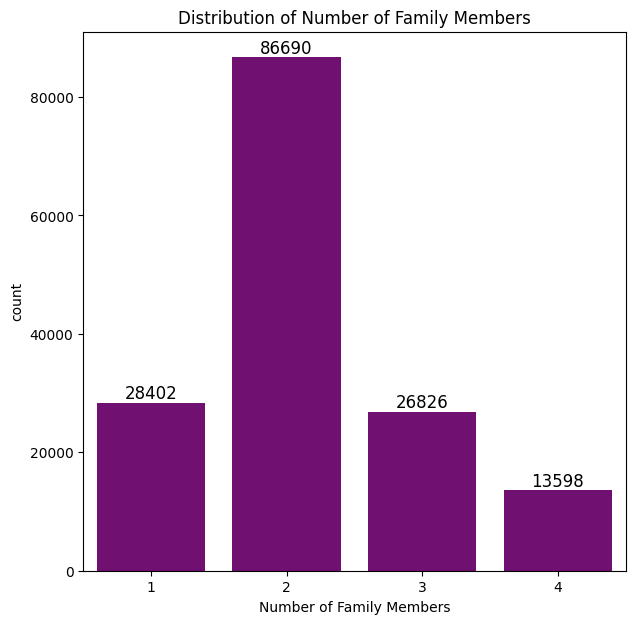

In [233]:
#CNT_FAM_MEMBERS      
plt.figure(figsize=(7,7))

#Create the countplot for verifiable income
g=sns.countplot(x='CNT_FAM_MEMBERS', data= df_merged,color='purple')
plt.xlabel('Number of Family Members')
plt.title('Distribution of Number of Family Members');

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

Most clients are in pairs (either married or civil)

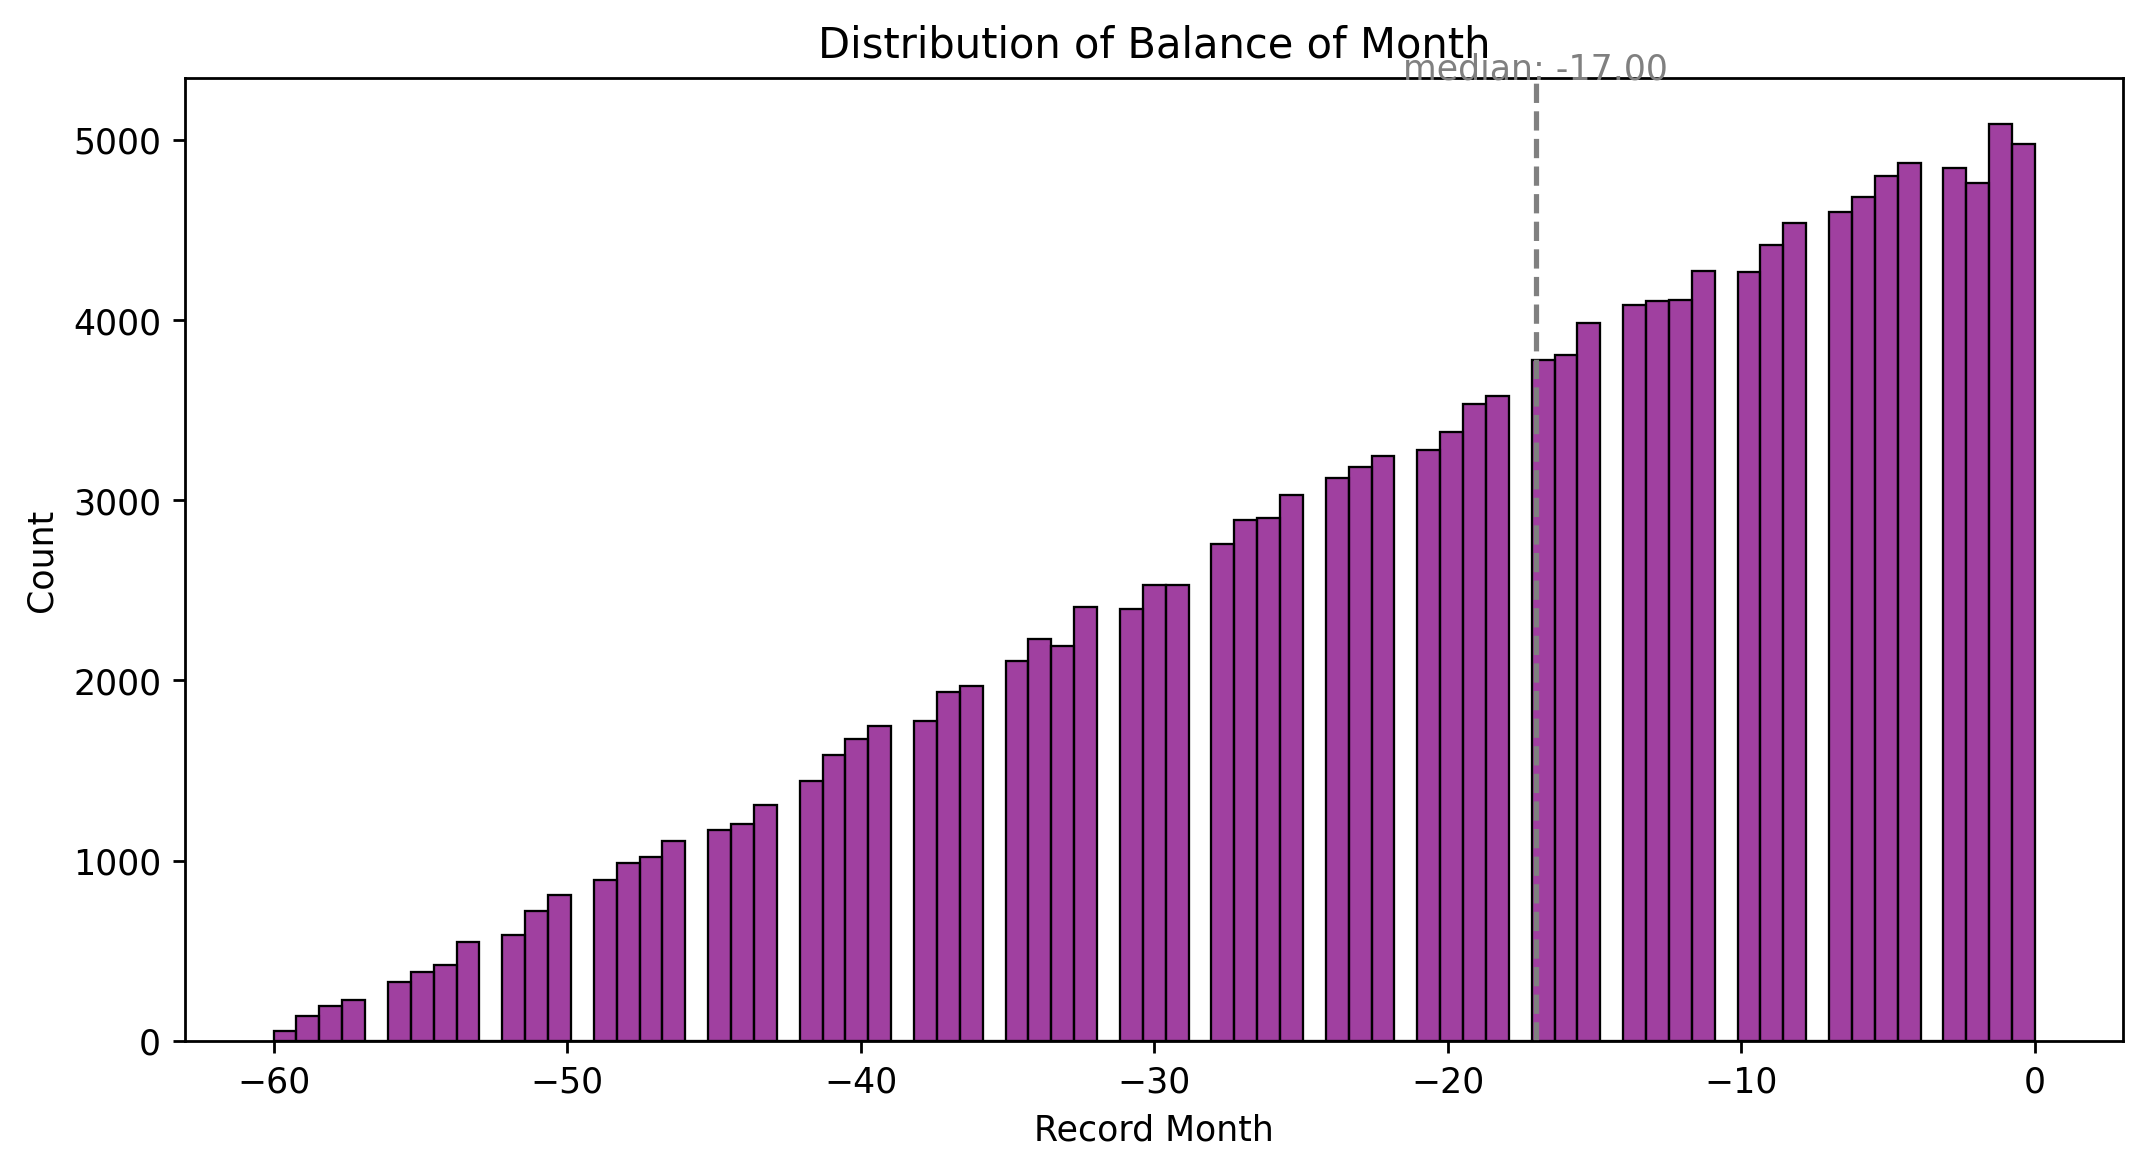

In [234]:
#MONTHS_BALANCE   

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=250)

# create histogram
sns.histplot(x='MONTHS_BALANCE', data=df_merged, ax=axes, color='purple')

#median
median = np.median(df_merged['MONTHS_BALANCE'])

#v-line and median value
axes.axvline(median, color='grey', linestyle='--')
axes.text(median, axes.get_ylim()[1] - 2, f"median: {median:.2f}", ha="center", color='grey')

plt.xlabel('Record Month')
plt.title('Distribution of Balance of Month');

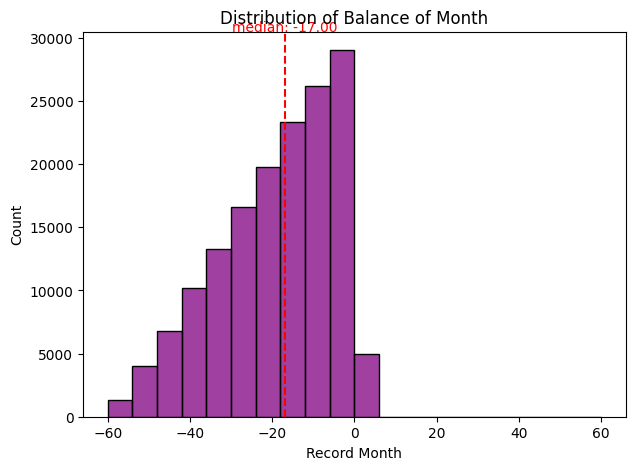

In [235]:
#MONTHS_BALANCE                 
plt.figure(figsize=(7,5))

# Create the histogram
sns.histplot(x='MONTHS_BALANCE', data=df_merged, bins=20, binrange=(-60, 60),color='purple')

# Calculate the median of the data
median = df_merged['MONTHS_BALANCE'].median()

# Add a vertical line at the median value
plt.axvline(median, color="r", linestyle="--")

# Add text displaying the median value
plt.text(median, plt.ylim()[1] - 2, f"median: {median:.2f}", ha="center", color="r")

plt.xlabel('Record Month')
plt.title('Distribution of Balance of Month');

majority of months are between -20 and -60 months

the median of the balance of the month IS -17

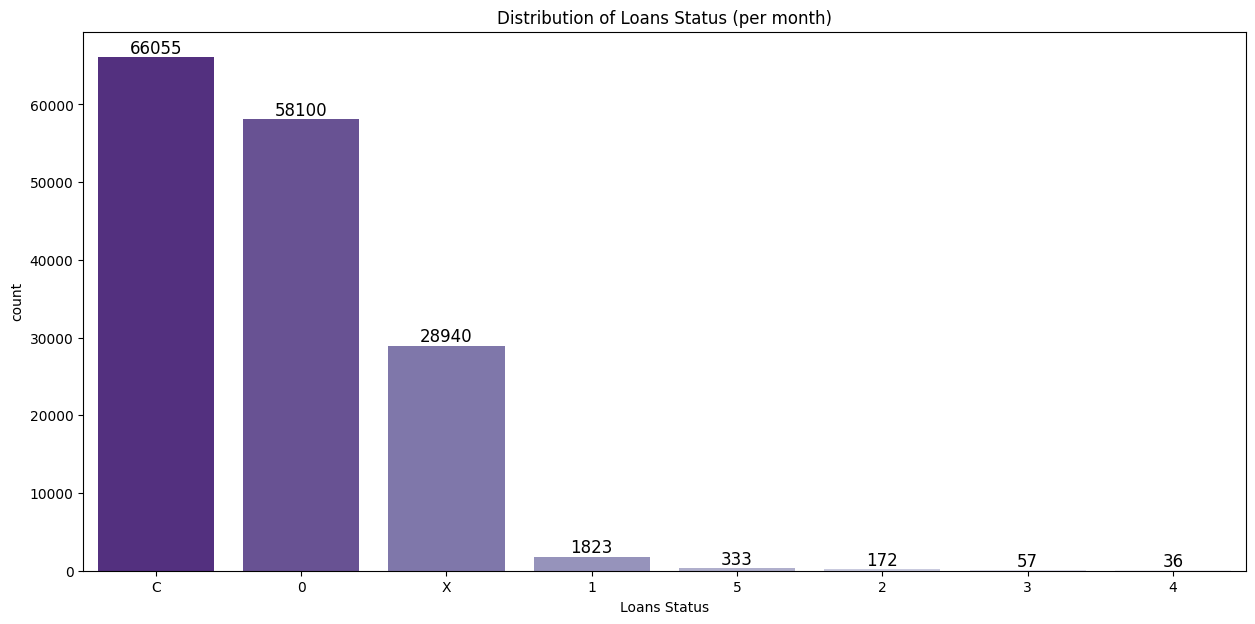

In [236]:
#STATUS    
   
plt.figure(figsize=(15,7))
#sort count order 
counts = df_merged['STATUS'].value_counts()

#Create the countplot 
g=sns.countplot(x='STATUS', data= df_merged,order=counts.index, palette='Purples_r')
plt.xlabel('Loans Status')
plt.title('Distribution of Loans Status (per month)');

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

The majority of the debts are paid off, followed by those past-due by only 1-29 days. Good borrowing status overall.

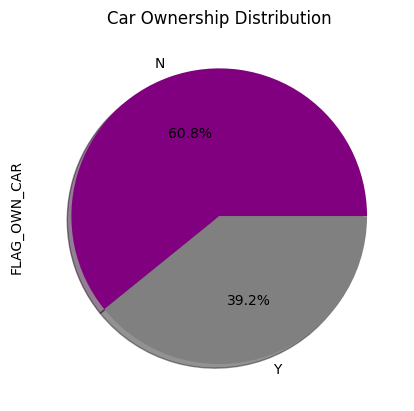

In [237]:
#FLAG_OWN_CAR            

#Create the pieplot for car
colors = ['purple', 'gray']
df_merged['FLAG_OWN_CAR'].value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%',colors=colors);
plt.title('Car Ownership Distribution');

60% do not own cars

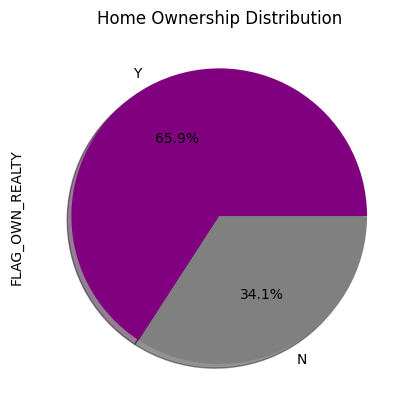

In [238]:
#FLAG_OWN_REALTY          

#Create the pieplot for realy
colors = ['purple', 'gray']
df_merged['FLAG_OWN_REALTY'].value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%',colors=colors);
plt.title('Home Ownership Distribution');

65% do not own a home 

## Cross-Correlation Analysis

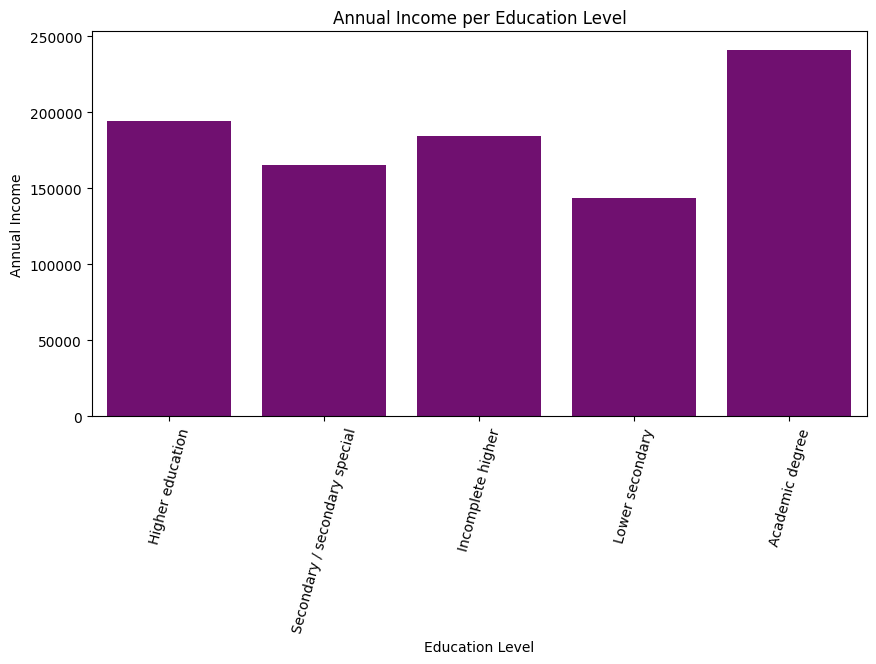

In [239]:
#Education and income   
plt.figure(figsize=(10,5))

#create barplot
sns.barplot(y='AMT_INCOME_TOTAL', x='NAME_EDUCATION_TYPE', data=df_merged, ci=False, color='purple')
plt.xticks(rotation=75)
plt.ylabel('Annual Income')
plt.xlabel('Education Level')
plt.title('Annual Income per Education Level');

Those with an academic degree form the lowest number of clients however, they tend to have a higher income than the rest 

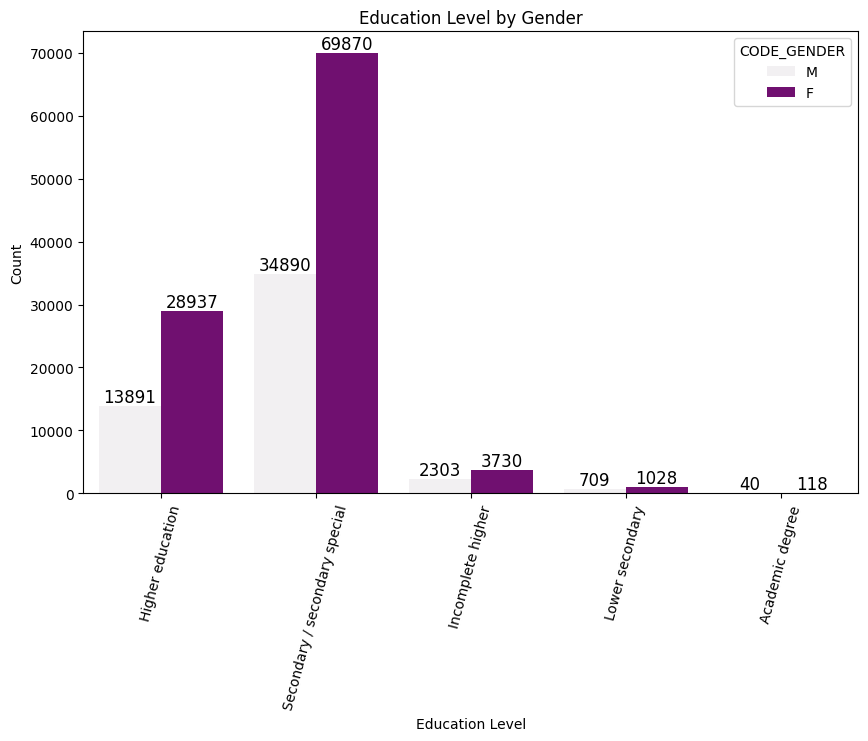

In [240]:
#education and gender
plt.figure(figsize=(10,6))

#plot countplot
g=sns.countplot(x='NAME_EDUCATION_TYPE', hue='CODE_GENDER', data=df_merged, color='purple')
plt.xticks(rotation=75)
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Education Level by Gender')

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom');


Females have the heighest level of education accross the board

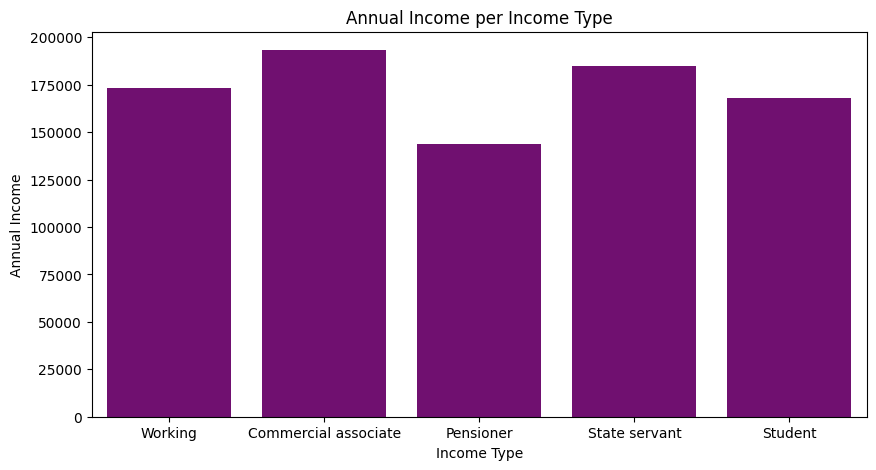

In [241]:
#annual income and income type
plt.figure(figsize=(10,5))

#create barplot
sns.barplot(x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL', data=df_merged, ci=False,color='purple')
plt.xlabel('Income Type')
plt.ylabel('Annual Income')
plt.title('Annual Income per Income Type');


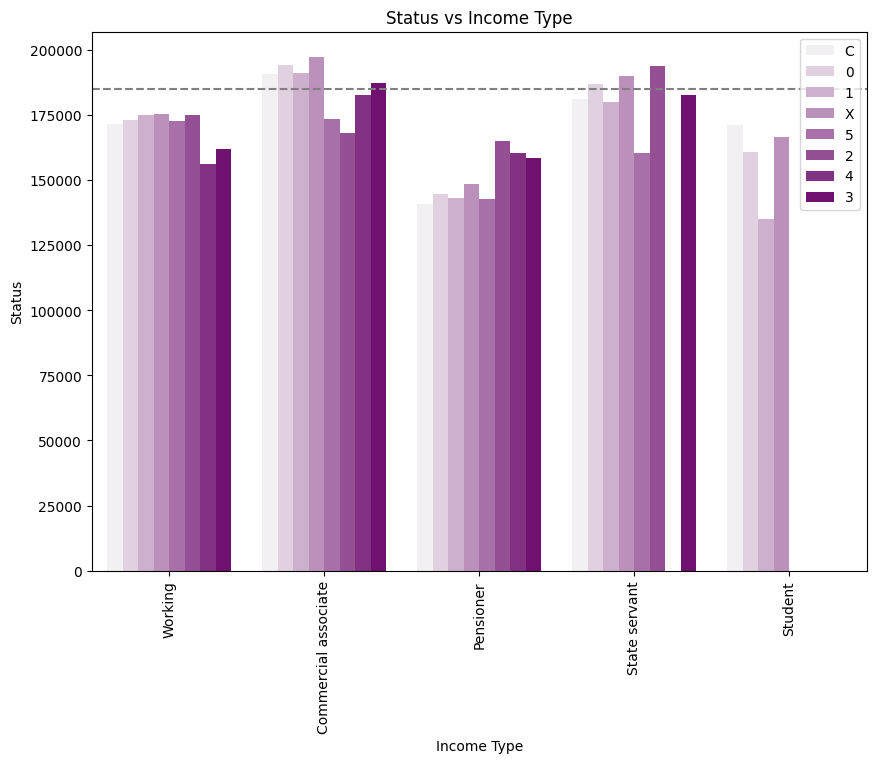

In [242]:
#Status and income type
plt.figure(figsize=(10,7))

# Create a plot
sns.barplot(x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL', hue='STATUS', data=df_merged, ci=False,color='purple')


plt.xlabel('Income Type')
plt.xticks(rotation=90)
plt.ylabel('Status')
plt.title('Status vs Income Type')
plt.axhline(y=185000, color='grey', linestyle='--')

#move legend
plt.legend(loc="upper right");

Commercial associates have the highest annual income.Their status, accros the board, is also the highest. 

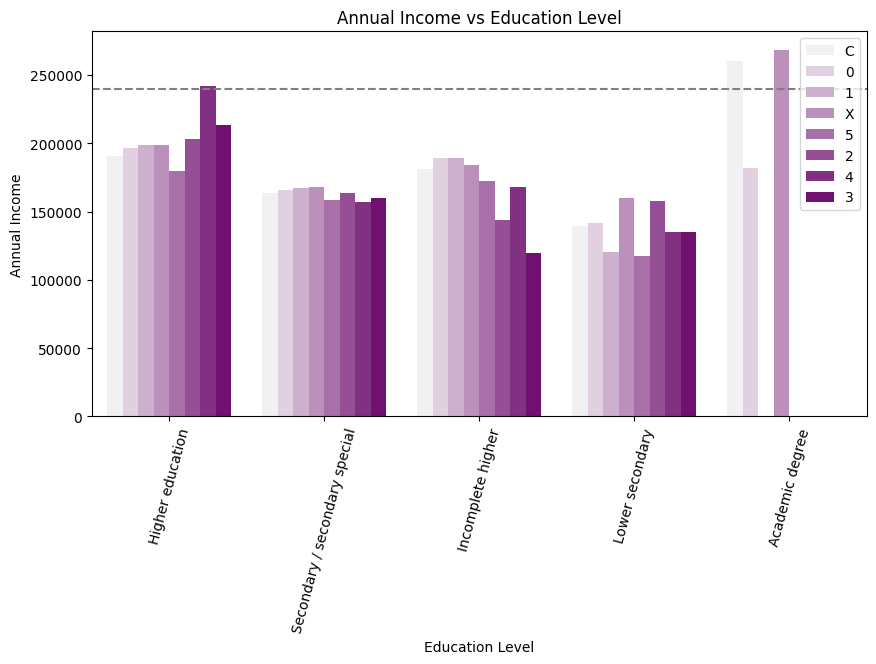

In [243]:
#Education, income and status
plt.figure(figsize=(10,5))

#create barplot
sns.barplot(y='AMT_INCOME_TOTAL', x='NAME_EDUCATION_TYPE', hue= 'STATUS', data=df_merged, ci=False,color='purple')
plt.xticks(rotation=75)
plt.ylabel('Annual Income')
plt.xlabel('Education Level')
plt.title('Annual Income vs Education Level')
plt.axhline(y=240000, color='grey', linestyle='--')

#move legend
plt.legend(loc="upper right");

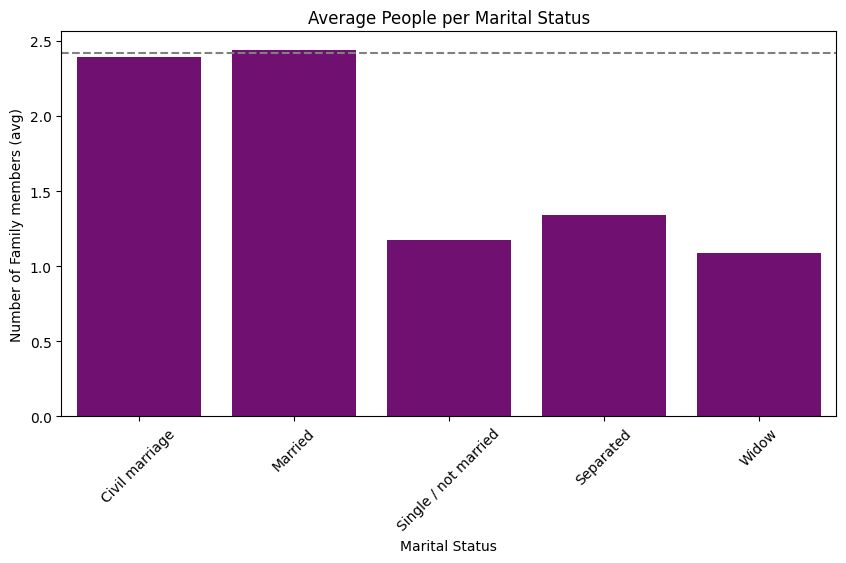

In [244]:
#Marital Status and Family number count
plt.figure(figsize=(10,5))

#plot bar plot
sns.barplot(x='NAME_FAMILY_STATUS', y='CNT_FAM_MEMBERS', data=df_merged, ci=False,color='purple')


plt.xticks(rotation=45)
plt.ylabel('Number of Family members (avg)')
plt.xlabel('Marital Status')
plt.title('Average People per Marital Status')
plt.axhline(y=2.42, color='grey', linestyle='--');

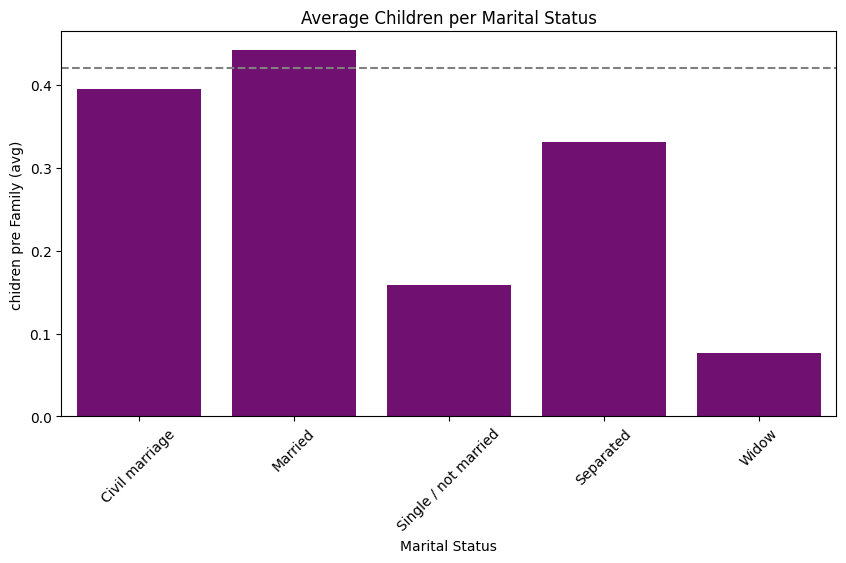

In [245]:
#income and no of children per family 
plt.figure(figsize=(10,5))

#plot bar plot
sns.barplot(x='NAME_FAMILY_STATUS', y='CNT_CHILDREN', data=df_merged, ci=False, color='purple')


plt.xticks(rotation=45)
plt.ylabel('chidren pre Family (avg)')
plt.xlabel('Marital Status')
plt.title('Average Children per Marital Status')
plt.axhline(y=.42, color='grey', linestyle='--');

Married clients have a slightly higher family member average compared to those that in civil marriage. They also have the highest average of children

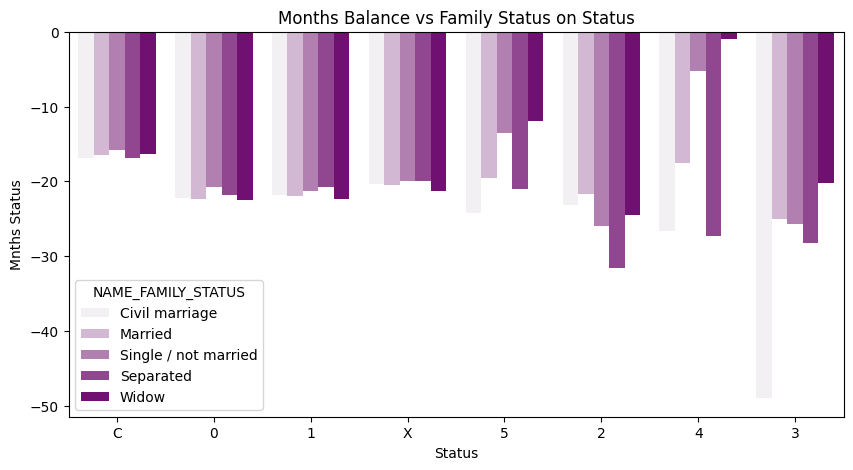

In [246]:
#Status Month Balance and marital status
plt.figure(figsize=(10,5))

#plot bar plot
sns.barplot(x='STATUS', y='MONTHS_BALANCE', hue='NAME_FAMILY_STATUS', data=df_merged, ci=False, color='purple')

plt.ylabel('Mnths Status')
plt.xlabel('Status')
plt.title('Months Balance vs Family Status on Status');

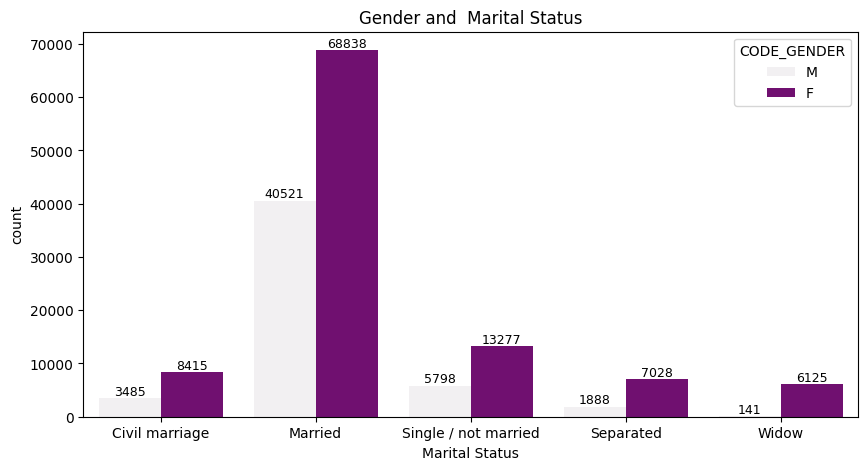

In [247]:
#gender and marital status
plt.figure(figsize=(10,5))

#create countplot
g=sns.countplot(x='NAME_FAMILY_STATUS', hue='CODE_GENDER', data=df_merged, color='purple')
plt.xlabel('Marital Status')
plt.title('Gender and  Marital Status');

# Add labels to the bars
for p in g.patches:
    g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=9, ha='center', va='bottom')

More female clients in all categories

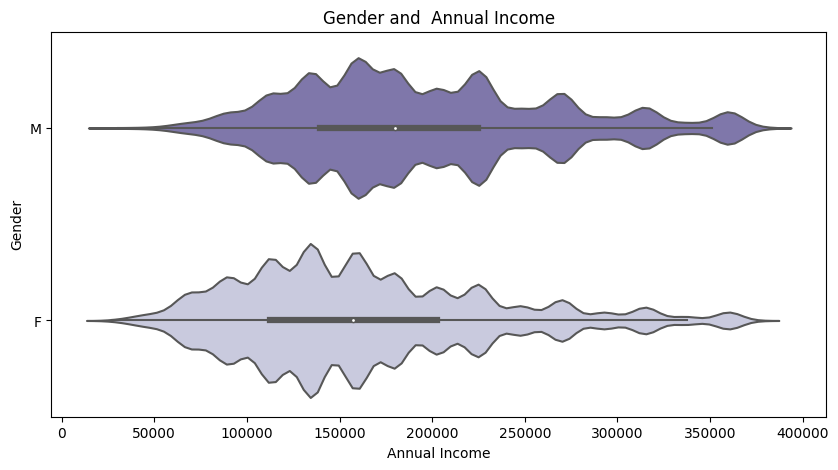

In [248]:
#gender and annual income
plt.figure(figsize=(10,5))

#create violinplot
sns.violinplot(x='AMT_INCOME_TOTAL', y='CODE_GENDER', data=df_merged, palette='Purples_r')
plt.xlabel('Annual Income')
plt.ylabel('Gender')
plt.title('Gender and  Annual Income');

There appears to be more females in the workforce, However the distribution of their median income is 150K per year, whereas the male’s median income seems to be 50K more per year. Is that the case for all the categories?

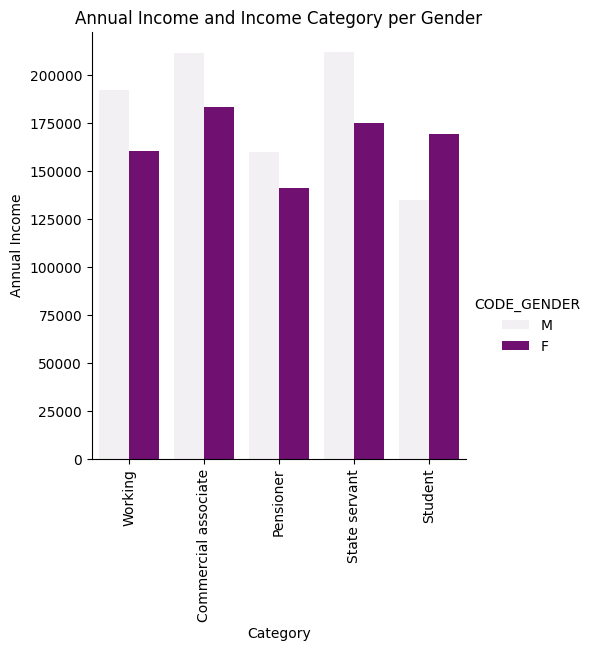

In [249]:
#catetgory and gender

#create barplot
sns.catplot(x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL', hue='CODE_GENDER', kind='bar', data=df_merged, ci=False,color='purple')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Annual Income')
plt.title('Annual Income and Income Category per Gender');

Only female students make more per year (on avg) than their male couterparts

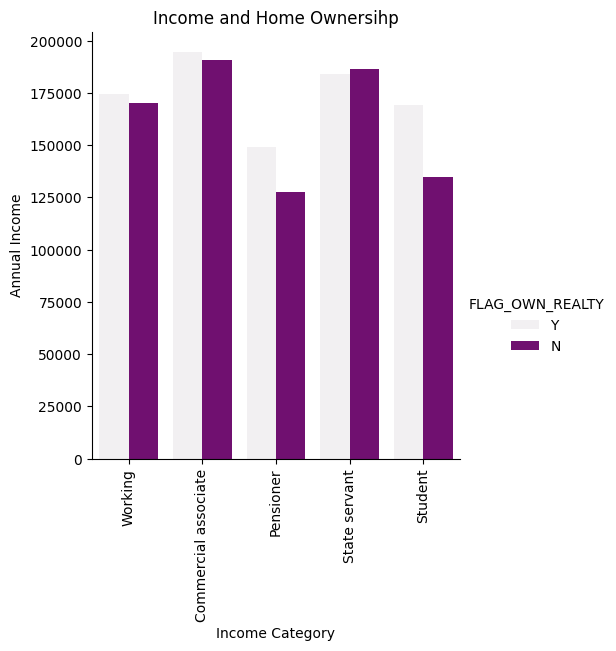

In [250]:
#income and home ownership

#plot barplot
sns.catplot(x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL',  hue='FLAG_OWN_REALTY', kind='bar', data=df_merged, ci=False, color='purple')

plt.xlabel('Income Category')
plt.ylabel('Annual Income')
plt.xticks(rotation=90)
plt.title('Income and Home Ownersihp');

More female state servants own a home compared to male state servants.

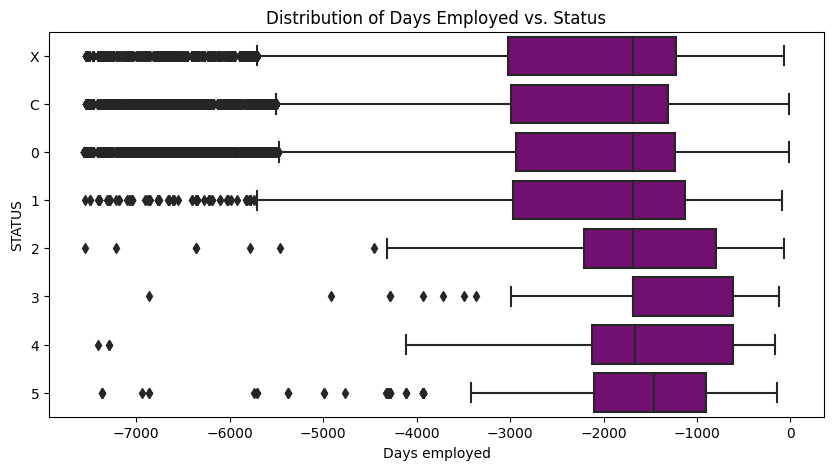

In [251]:
#Days Employed & Status    
plt.figure(figsize=(10,5))

#set status order from no loan this month, good to bad
status_order = ['X','C', '0', '1', '2', '3', '4', '5']

# create plot
sns.boxplot(x='DAYS_EMPLOYED', y='STATUS', data=df_merged, order=status_order, color='purple')


plt.xlabel('Days employed')
plt.title('Distribution of Days Employed vs. Status');

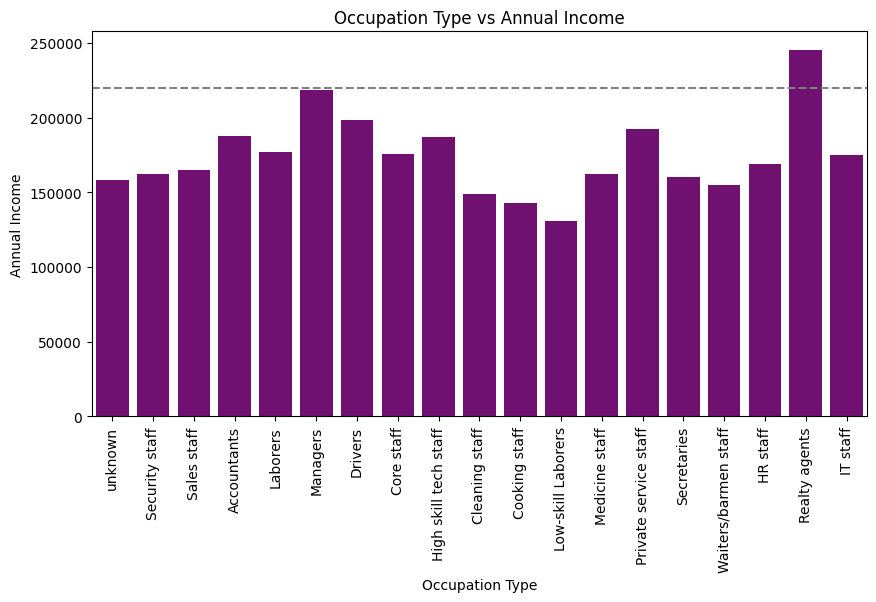

In [252]:
# Set the figure size
plt.figure(figsize=(10,5))

# Plot the grouped bar chart
sns.barplot(x='OCCUPATION_TYPE', y='AMT_INCOME_TOTAL', data=df_merged, ci=False, color='purple')
plt.xlabel('Occupation Type')
plt.xticks(rotation=90)
plt.ylabel('Annual Income')
plt.title('Occupation Type vs Annual Income')
plt.axhline(y=220000, color='grey', linestyle='--');

Realty agents have the highest average yearly income

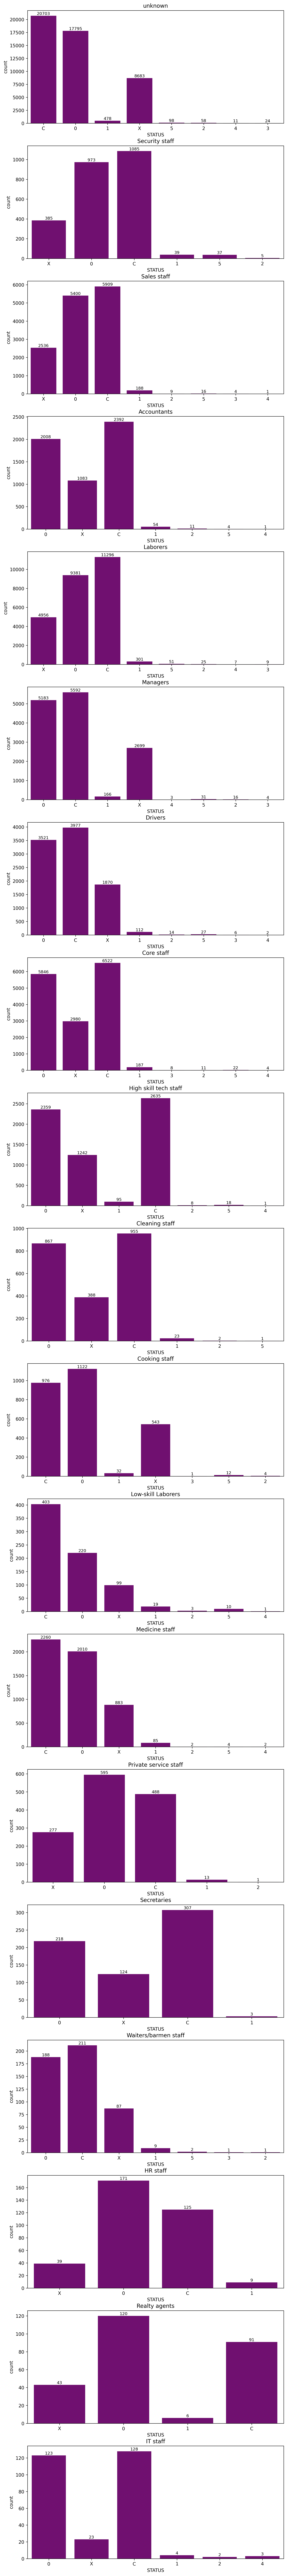

In [253]:
#each occupation's status
occupations = df_merged['OCCUPATION_TYPE'].unique()

# Create subplots
fig, ax = plt.subplots(nrows=19, ncols=1, figsize=(10, 100), dpi=250)

for i, occ in enumerate(occupations):
    sns.countplot(x='STATUS', data=df_merged[df_merged['OCCUPATION_TYPE'] == occ], color='purple', ax=ax[i])
    ax[i].set_title(f"{occ}")
    
# Add labels
    for p in ax[i].patches:
        ax[i].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=9, ha='center', va='bottom')

Most occupations are either 0, C or X

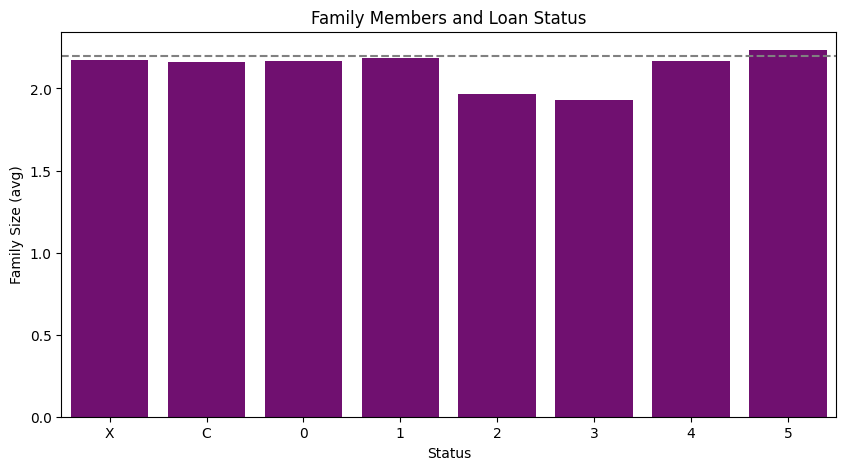

In [254]:
#Status and family size
plt.figure(figsize=(10,5))

#set status order from no loan this month, good to bad
status_order = ['X','C', '0', '1', '2', '3', '4', '5']

#plot bar plot
sns.barplot(x='STATUS', y='CNT_FAM_MEMBERS', data=df_merged, ci=False, order=status_order,color='purple')

plt.ylabel('Family Size (avg)')
plt.xlabel('Status')
plt.title('Family Members and Loan Status')
plt.axhline(y=2.2, color='grey', linestyle='--');

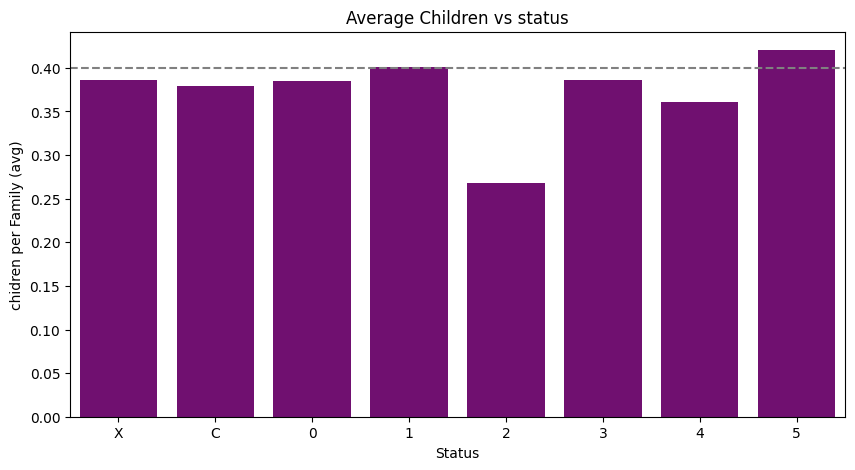

In [255]:
#status and no. of children    
plt.figure(figsize=(10,5))

#set status order from no loan this month, good to bad
status_order = ['X','C', '0', '1', '2', '3', '4', '5']

#plot bar plot
sns.barplot(x='STATUS', y='CNT_CHILDREN', data=df_merged, ci=False, order=status_order,color='purple')

plt.ylabel('chidren per Family (avg)')
plt.xlabel('Status')
plt.title('Average Children vs status')
plt.axhline(y=0.4, color='grey', linestyle='--');

The families with the highest average members have the worse status

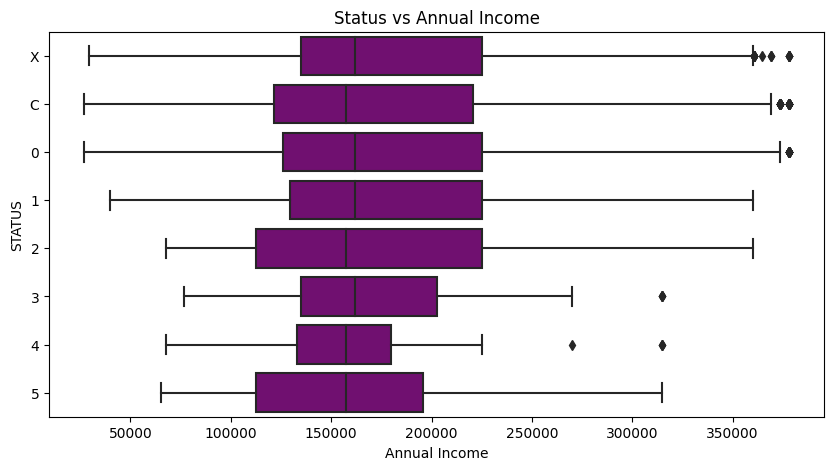

In [256]:
#status and income
plt.figure(figsize=(10,5))

#set status order from no loan this month, good to bad
status_order = ['X','C', '0', '1', '2', '3', '4', '5']

#create plot
sns.boxplot(y='STATUS', x='AMT_INCOME_TOTAL', data=df_merged, order=status_order,color='purple')

plt.xlabel('Status')
plt.xlabel('Annual Income')
plt.title('Status vs Annual Income');

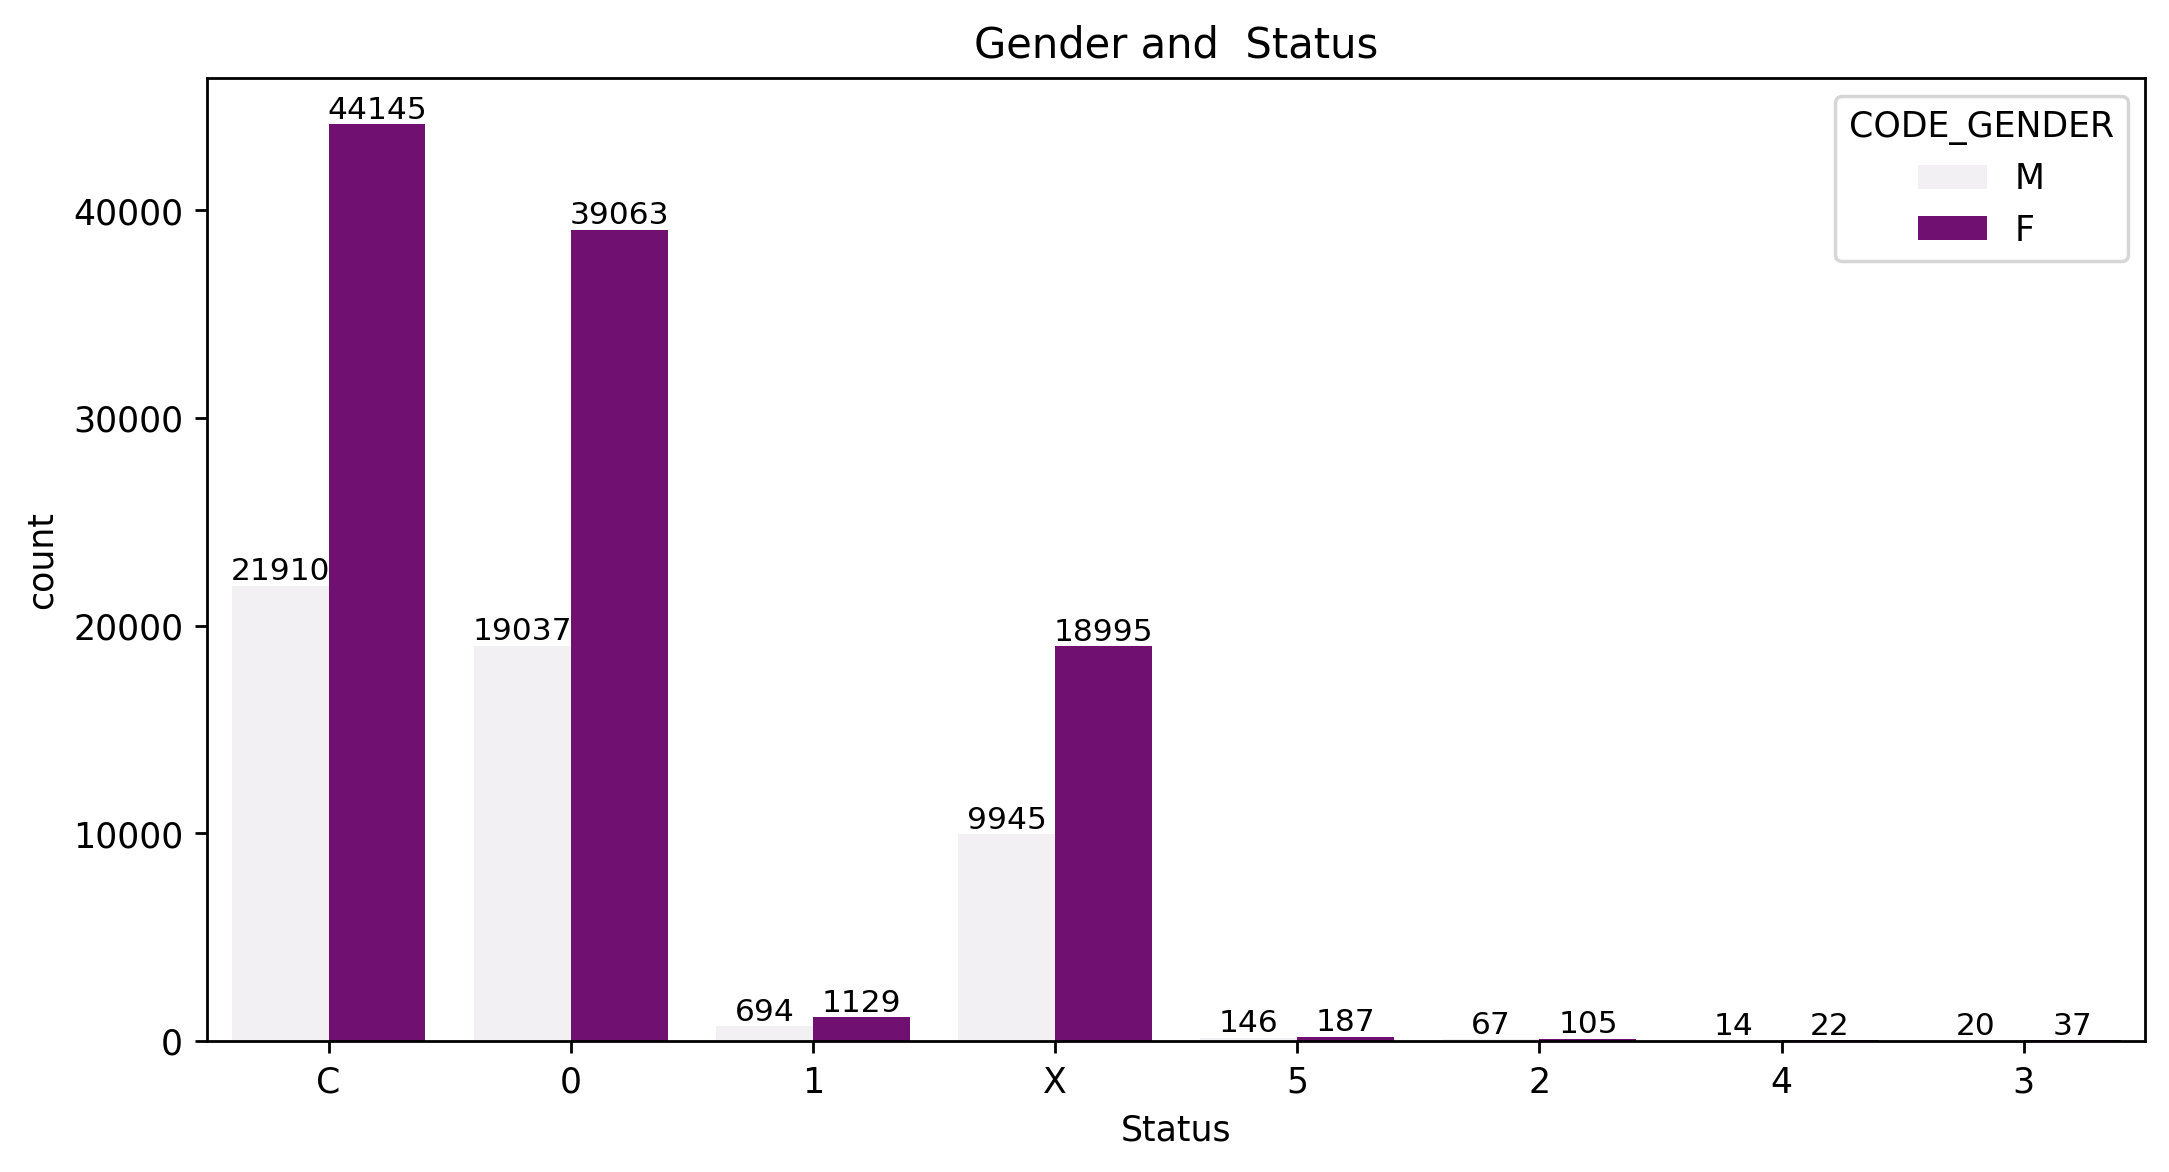

In [257]:
#status and gender

#subplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=250)

#plot countplot
g=sns.countplot(x='STATUS', hue='CODE_GENDER', data=df_merged,color='purple')
plt.xlabel('Status')
plt.title('Gender and  Status');

# Add labels to the bars
for p in g.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=9, ha='center', va='bottom')

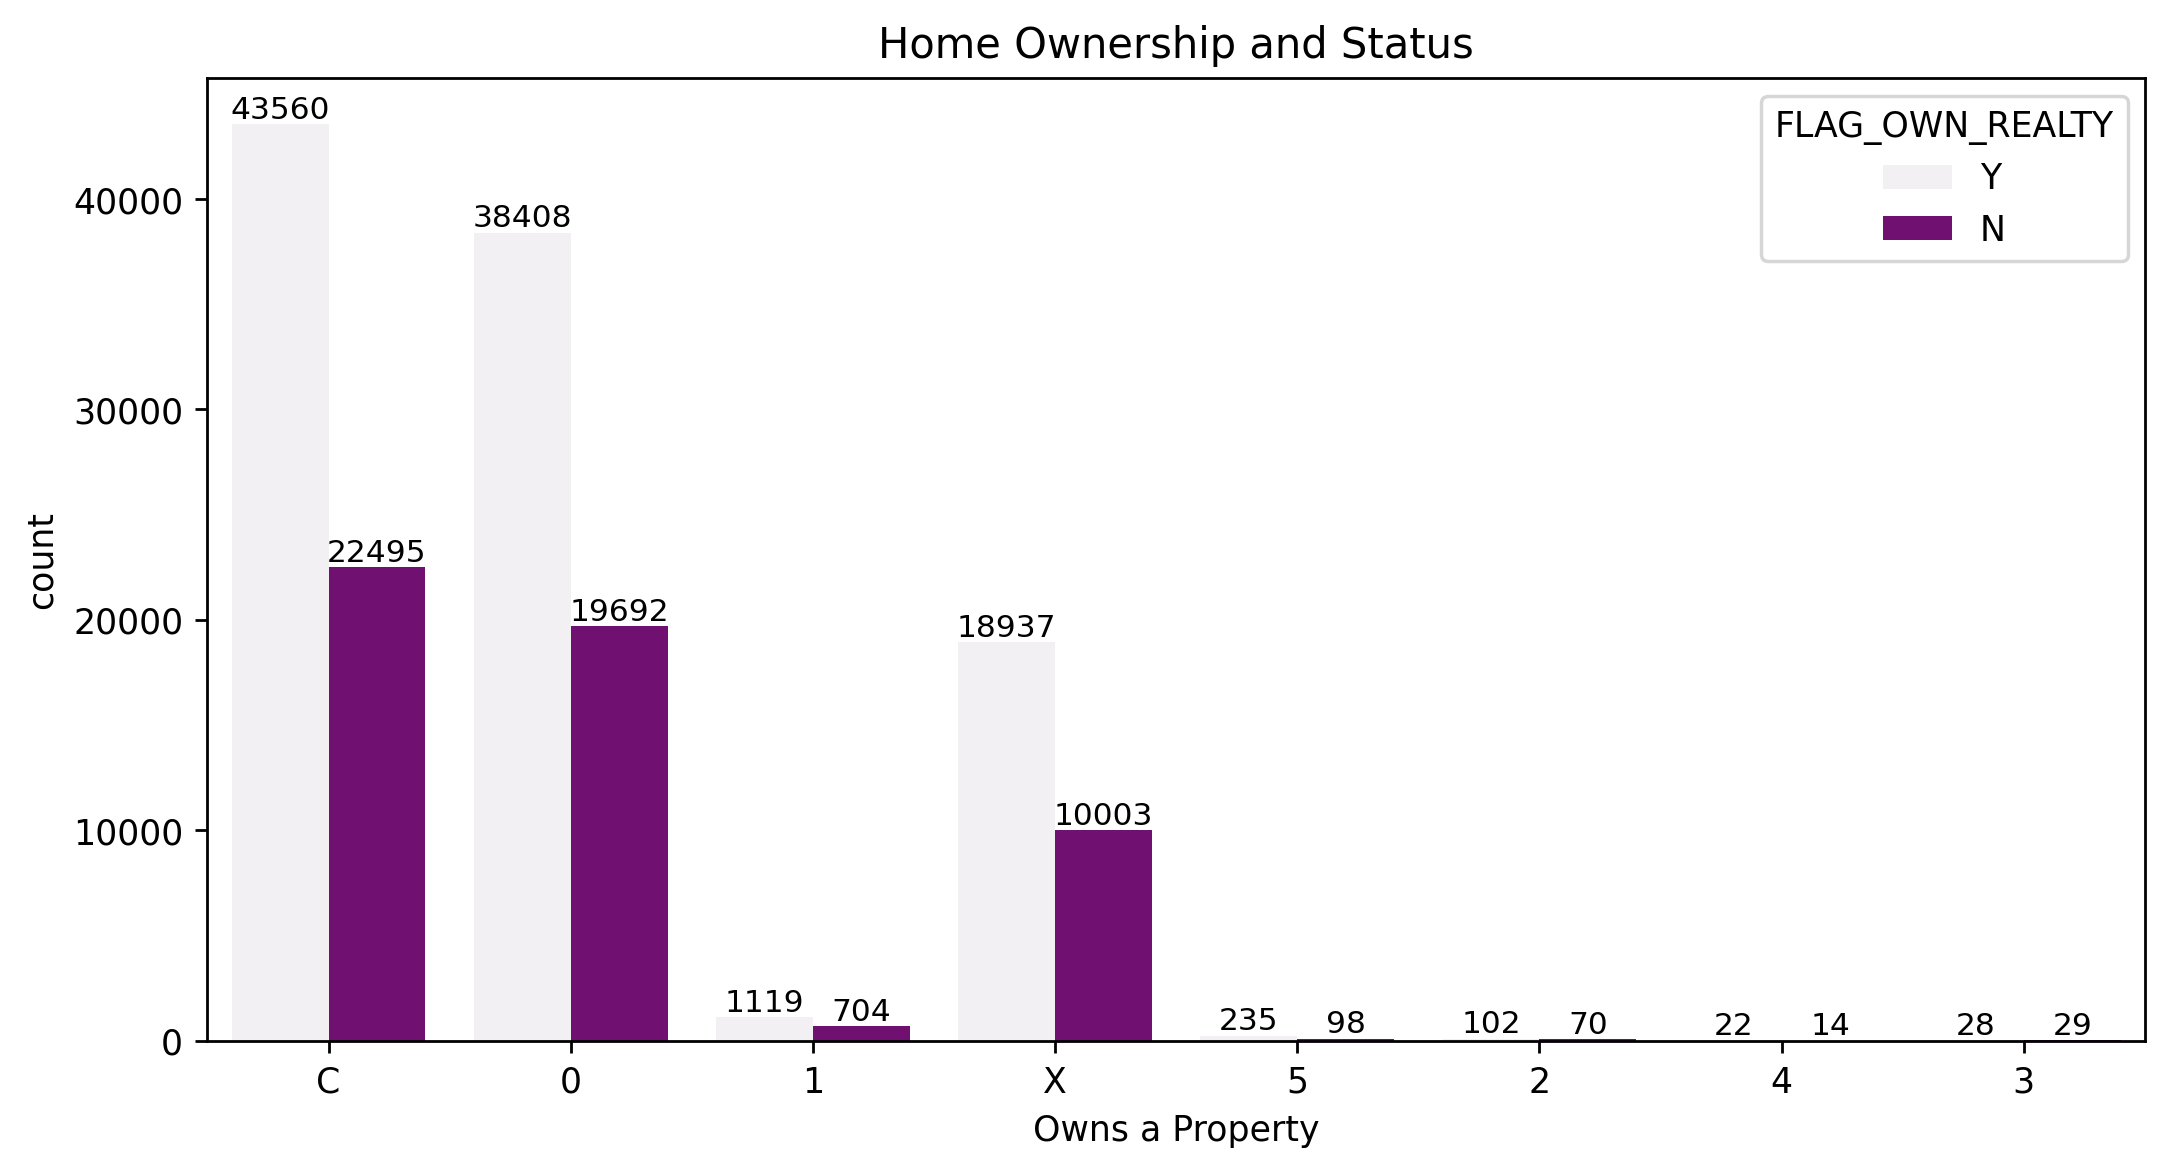

In [258]:
#status and home ownership 

#subplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=250)

# create countplot
g=sns.countplot(x='STATUS', hue='FLAG_OWN_REALTY', data=df_merged,color='purple')
plt.xlabel('Owns a Property')
plt.title('Home Ownership and Status');

# Add labels to the bars
for p in g.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=9, ha='center', va='bottom')

There are more homeowners compared to non-homeowners.Although there is a considerable gap between homeowners and non-homeowners they all fall in the same three categories C, 0 and X

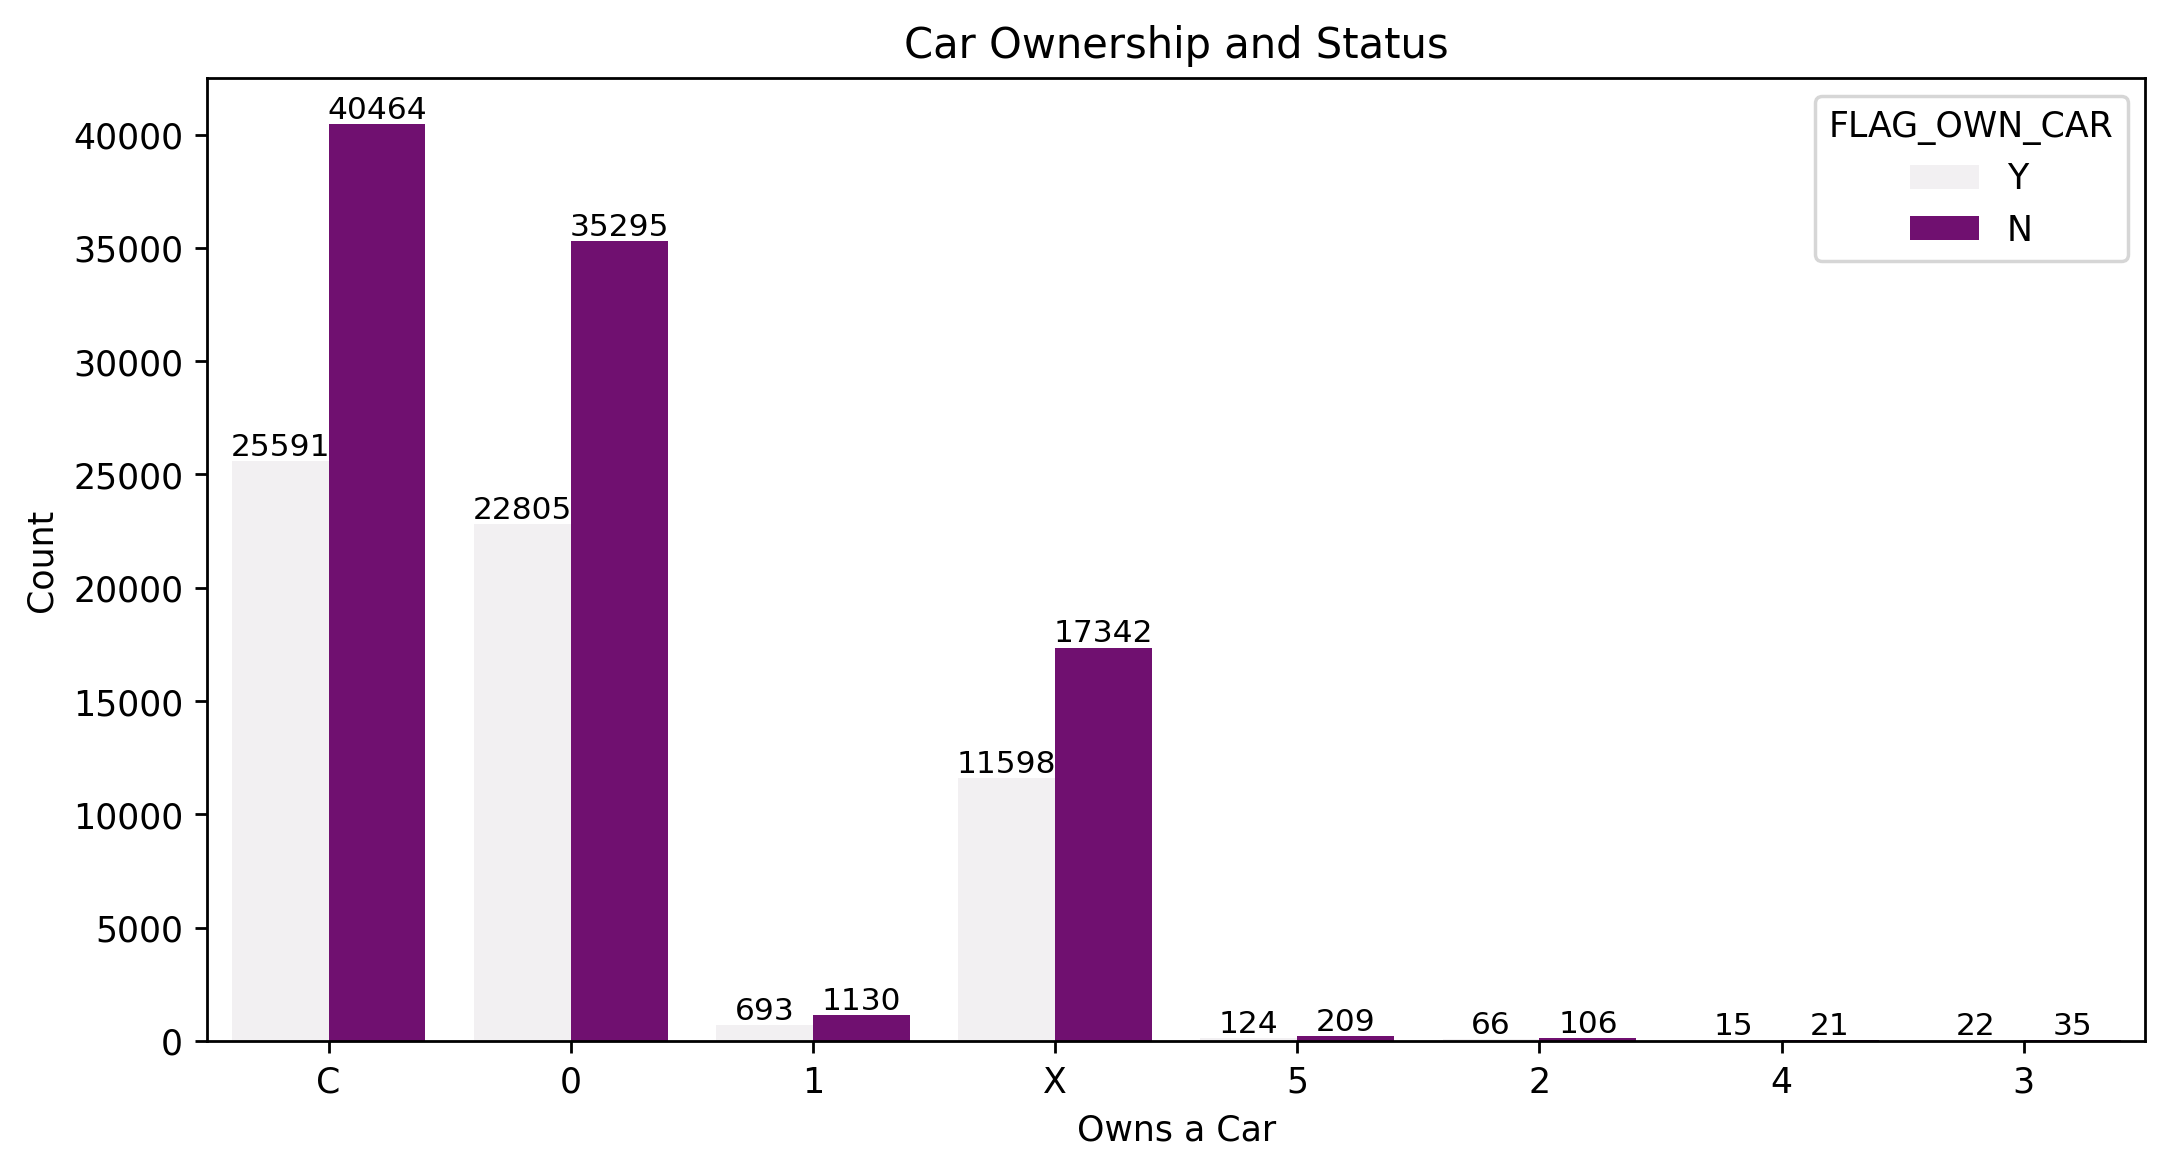

In [259]:
#status and car ownership 

#subplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=250)

# create countplot
g = sns.countplot(x='STATUS', hue='FLAG_OWN_CAR', data=df_merged, ax=ax,color='purple')
ax.set_xlabel('Owns a Car')
ax.set_ylabel('Count')
ax.set_title('Car Ownership and Status')

# Add labels to the bars
for p in g.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=9, ha='center', va='bottom')

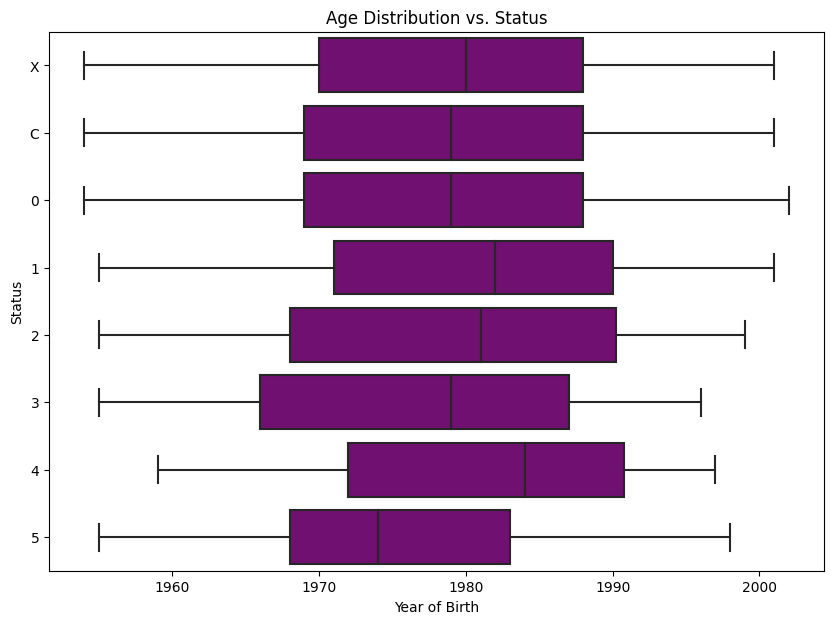

In [260]:
#Year of birth and Status
plt.figure(figsize=(10,7))

#set status order from no loan this month, good to bad
status_order = ['X','C', '0', '1', '2', '3', '4', '5']

# Create a BIRTH_YEAR column
df_merged['BIRTH_YEAR'] = df_merged['BIRTH_DATE'].dt.year

# Create violin plot
sns.boxplot(x='BIRTH_YEAR', y='STATUS', data=df_merged, order= status_order, color='purple')
plt.xlabel('Year of Birth')
plt.ylabel('Status')
plt.title('Age Distribution vs. Status');

The distribution for X, C, and 0 are all between 1970 and the end of the 1980's with the median birth year being in the early 1980's.

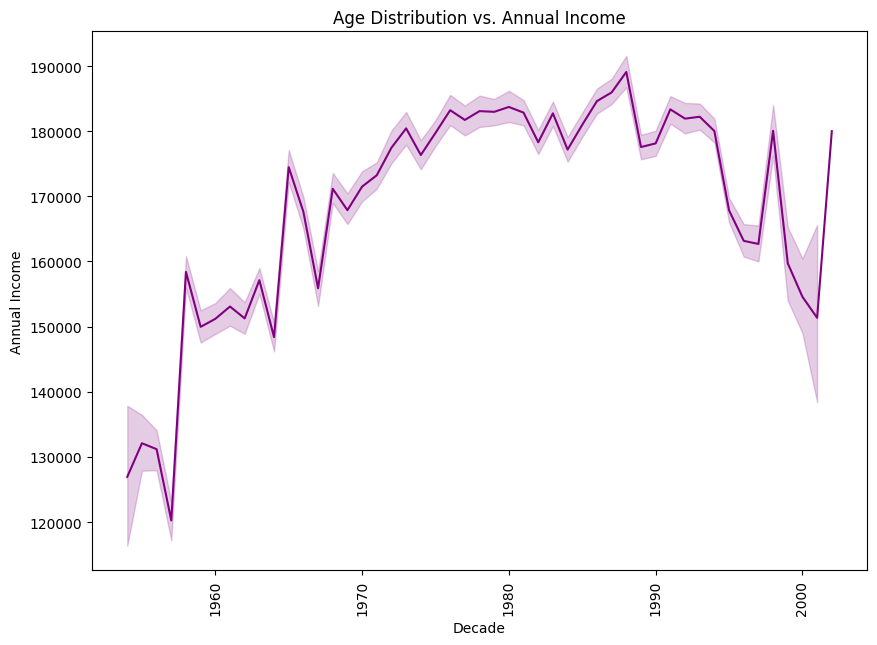

In [261]:
#Year of birth and annual income
plt.figure(figsize=(10,7))

# Create  plot
sns.lineplot(x='BIRTH_YEAR', y='AMT_INCOME_TOTAL', data=df_merged,color='purple')

plt.xlabel('Decade')
plt.xticks(rotation=90)
plt.ylabel('Annual Income')
plt.title('Age Distribution vs. Annual Income');

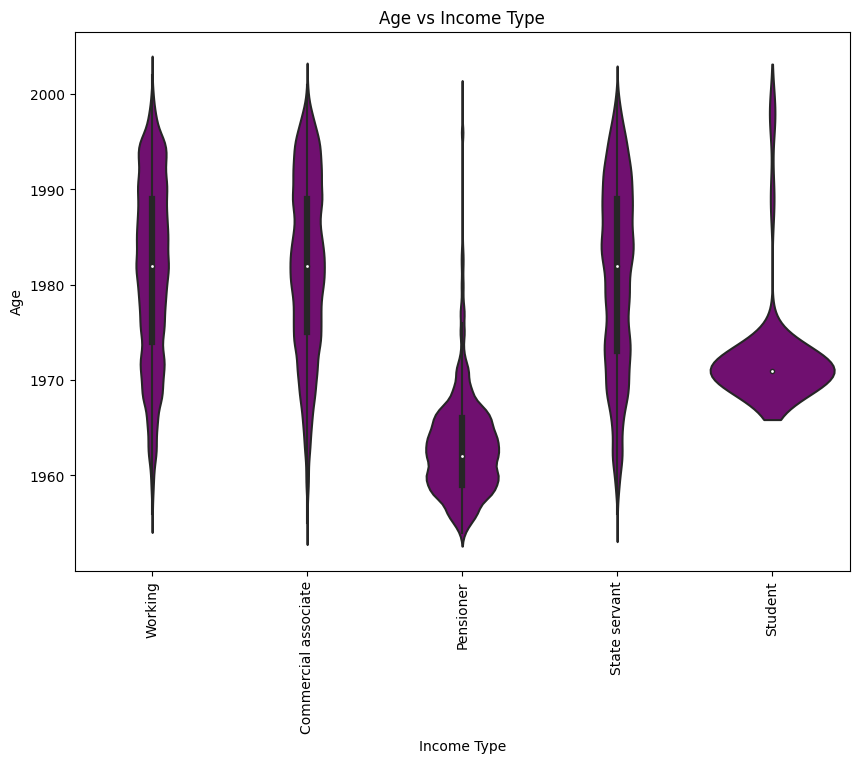

In [262]:
#Year of birth and annual income
plt.figure(figsize=(10,7))

# Create a plot
sns.violinplot(x='NAME_INCOME_TYPE', y='BIRTH_YEAR', data=df_merged, color='purple')


plt.xlabel('Income Type')
plt.xticks(rotation=90)
plt.ylabel('Age')
plt.title('Age vs Income Type');

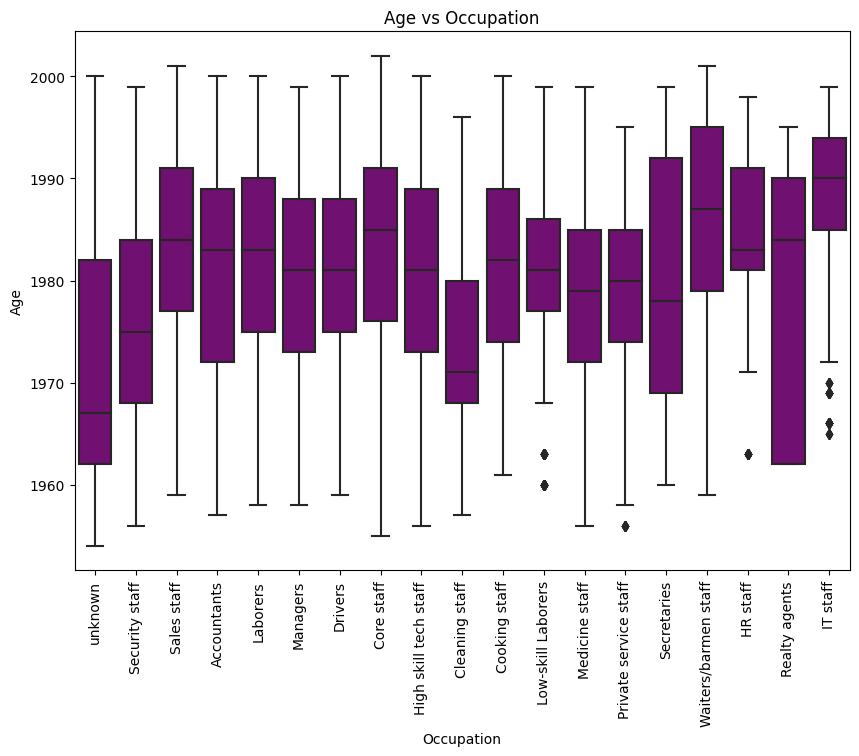

In [263]:
#Year of birth and occupation
plt.figure(figsize=(10,7))

# Create a plot
sns.boxplot(x='OCCUPATION_TYPE', y='BIRTH_YEAR', data=df_merged,color='purple')

plt.xlabel('Occupation')
plt.xticks(rotation=90)
plt.ylabel('Age')
plt.title('Age vs Occupation');

## Raising Data Questions

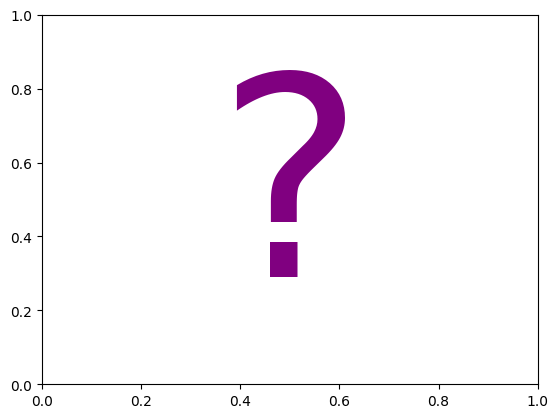

In [264]:
fig, ax = plt.subplots()
ax.text(0.5, 0.5, "?", color="purple", size=200, ha="center", va="center")
plt.show()

When analyzing the distribution of annual income among clients in the dataset, it appears that the majority of clients have an annual income between a little over $100,000 and under $250,000. This is supported by a visualization that also shows the median income of the clients to be over a little over 150,000. This suggests that the majority of clients are part of the middle to upper-middle class range. However, there are also some clients with higher incomes, but they are less frequent.

In terms of age and annual income, while there is some variability in income across different age groups, it does not appear to increase consistently with age. In fact, it seems that older people may not necessarily make more money. This is supported by the fact that there are many older individuals in the dataset with lower annual incomes(the pensioners, maybe). It is worth noting that the spread of incomes within age groups is quite wide, which suggests that other factors may play a more significant role in determining one's income than age alone.

Lastly, our analysis of the correlation between homeownership and loan status revealed that there is a relationship between the two factors. It appears that homeowners are more likely to repay their loans on time, compared to the non-homeowners. This may be because homeowners have a vested interest in maintaining their good credit standing, as their home probably serves as collateral for the loan. They may also have a more stable source of income.

In conclusion, there are a variety of factors that can affect a client's ability to repay a loan (status), for example their occupation, and their age and annual income and finally their homeownership status.

## Data Enrichment

With unlimited resources, budget, and access to data, I would aim to enhance the current dataset by taking the following steps:

Firstly, my objective would be to acquire missing occupation types for clients in the dataset. This information can provide valuable insights into a client's type of work, income level, and likelihood of default. By having a complete set of data on occupation types, we can more accurately assess the risk associated with lending to certain clients.

Secondly, I would attempt to include information on values of the clients' assets such as savings and real estate investments and liabilities, such as mortgages and student loans. This information can provide insight into their overall financial health and ability to repay loans. This information can be obtained through bank statements, tax returns, and financial disclosures.

Thirdly, I would consider the clients’ location data, such as their neighbourhood or postal code. This information can be used to determine the clients' disposable income, socio-economic status, and living expenses, which can impact their ability to repay a loan.

To gather all the necessary information, we could ask our clients directly either through banking portals or by collecting it in-person through our tellers. Since I would still be looking out for missing values, I would use an outer join to combine the new dataset with the existing df_merged dataset on the primary key, the borrowers' ID. This would result in a comprehensive dataset that includes, in addition to the existing data,  the missing occupation details, savings and additional assets information, and location..

By incorporating this additional financial information, we can make more informed lending decisions by having a complete picture of the borrower's financial situation and behaviour.

## Recommendations

The purpose of this document is to provide specific business recommendations based on the analysis performed on the existing dataset of HereIsTheMoney Bank.. The goal of this analysis was to gain a comprehensive understanding of the clients' financial situation and behavior. Through the analysis, we have uncovered several key insights that can be used to inform business decisions.


Recommendation 1: Obtain Missing Occupation Types

Another key finding from the analysis was the missing information on occupation types for some clients in the dataset. This information is critical in assessing the risk associated with lending to certain clients and can provide valuable insight into a client's type of work, income level, and likelihood of default. This information can be obtained through a combination of direct client engagement, namely and data collection from other sources such as tax returns and financial disclosures.

Recommendation 2: Incorporate Information on Additional Assets

A third key finding from the analysis was the lack of information on value of the assets (home/car) and any additional assets such as savings and real estate investments as well as liabilities. This information can provide insight into a client's debt-to-income ratio and overall financial health and ability to repay loans. To address this issue, we recommend incorporating information on additional assets into the dataset in order to create a debt-to-income ratio column. This information can be obtained through direct contact with clients via online portals bank statements, tax returns, and financial disclosures.

Recommendation 3: Consider Client Location

The last key finding from the analysis was the lack of information on client location. This information can be used to provide a more detailed representation of a client's income and socio-economic status. To address this issue, we recommend incorporating client location information into the dataset. 


By incorporating the family size, missing information on occupation types, value of assets, and client location, we can make more informed lending decisions and better understand the financial situation and behavior of our clients.
